# QCD

**Physics Qs:** 

1) How many QCD slices do we need to describe the data?
2) What do the data / MC c.f. look like in sidebands
3) What would the signal contamination look like for(?)


**Plan:** I have a workflow already for `processDf`, so maybe I should try to see how this scales??


In [2]:
import h5py
import awkward as ak
import uproot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import operator as SmoothOperator

import os
os.sys.path.append('../RRevolution/code/')
os.sys.path.append('../PyATLASstyle/')

from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

d = {'pt':'pt','eta':'eta','phi':'phi','energy':'E'}


from glob import glob
import pandas as pd

from analysis import processDf, do_min_dR_all, defineCuts, getXhh
from trigger import trigger_lut, bucket_config_generator, assign_bucket, get_nr_bucket
from utils import L, mcToYr

import PyATLASstyle as pas
pas.applyATLASstyle(mpl)
from colors import *

%load_ext autoreload
%autoreload 2

In [3]:
uproot.__version__

'4.1.9'

**Idea:** Test out the `processDf` code with a single test file.

For $HH \rightarrow 4b$, we looked at the JZ2-4 slices, maybe this is sufficient here as well?

In [4]:
save_cols = ['njets', 'ntag', 'X_wt_tag', 'mc_sf','bucket']

In [ ]:
%%time

evts_list = []
hc_jets_list = []

fnames = glob(fnames_JZ3)

for i,fname in enumerate(fnames[:10]):
    break
    print(f'\nFile {i+1:2d} / {len(fnames)}')
    
    evts, hc_jets = processDf(fname,min_btags=4,year=year,truth=False)

    evts_list.append(evts[save_cols])
    hc_jets_list.append(hc_jets)
    
evts = pd.concat(evts_list)
hc_jets = ak.concatenate(hc_jets_list)

In [5]:
f = uproot.open(fname)
f.keys()

NameError: name 'fname' is not defined

In [ ]:
len(f.keys())

In [ ]:
f['CutBookkeeper_364703_310000_NOSYS'].to_numpy()

**Initial Q:** What's the "pass rate" for these files?

In [ ]:
tname="AnalysisMiniTree"

In [ ]:
num_entries = 0
for i,fname in enumerate(fnames[:10]):
    
    t = uproot.open(f'{fname}:{tname}')
    num_entries += t.num_entries
    

In [ ]:
len(evts) / num_entries

Gosh! Just a fraction of a %.

In [ ]:
%%bash
ls ../data/JZ2_mc20e-MAR23/

In [3]:
jz_name = '../data/JZ{}_mc20e-MAR23/df_{}_4b_DL1d77_4b.parquet'

jz1 = pd.read_parquet(jz_name.format(1,'min_dR'))
jz2 = pd.read_parquet(jz_name.format(2,'min_dR'))
jz3 = pd.read_parquet(jz_name.format(3,'min_dR'))
jz4 = pd.read_parquet(jz_name.format(4,'min_dR'))
jz5 = pd.read_parquet(jz_name.format(5,'min_dR'))

OK, these files _don't_ have the 
1) $\Delta \eta_{SH} < 1.5$ cut
2) $X_{Wt} > 1.5$
3) $X_{SH} < 1.6$
cuts applied.

In [4]:
for i,df in zip([1,2,3,4,5],[jz1,jz2, jz3, jz4,jz5]):
    
    print(f'\nJZ{i}: {len(df)} raw evts')
    ttl = df.mc_sf.sum()
    
    mask = True
    for m in [df.dEta_SH < 1.5,df.X_wt_tag>1.5]:
        mask = m&mask
    
        print(f'  {df.loc[mask,"mc_sf"].sum() / ttl:.3} evts, {mask.sum()} raw evts')


JZ1: 6 raw evts
  0.66 evts, 4 raw evts
  0.0309 evts, 1 raw evts

JZ2: 748 raw evts
  0.493 evts, 398 raw evts
  0.191 evts, 174 raw evts

JZ3: 16094 raw evts
  0.542 evts, 9361 raw evts
  0.295 evts, 5077 raw evts

JZ4: 39210 raw evts
  0.612 evts, 25200 raw evts
  0.358 evts, 14957 raw evts

JZ5: 12505 raw evts
  0.661 evts, 8585 raw evts
  0.417 evts, 5328 raw evts


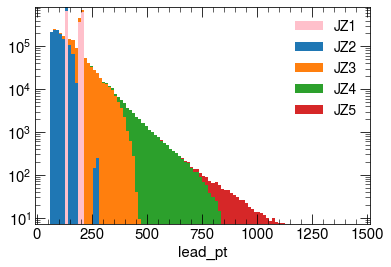

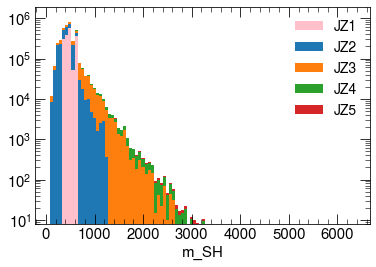

In [10]:
jz_colors = ['pink']+[f'C{i}' for i in range(4)]

for col in ['lead_pt','m_SH']:
 
    plt.figure()
    plt.hist([jz1[col],jz2[col],jz3[col],jz4[col],jz5[col]],100,histtype='barstacked',
             label=['JZ1','JZ2','JZ3','JZ4','JZ5'],color=jz_colors,
             weights=[jz1['mc_sf'],jz2['mc_sf'],jz3['mc_sf'],jz4['mc_sf'],jz5['mc_sf']])


    plt.legend()
    plt.xlabel(col)

    plt.yscale('log')

In [11]:
m1 = (jz1.dEta_SH < 1.5) & (jz1.X_wt_tag>1.5) #& (jz2.X_SH< 1.6)
m2 = (jz2.dEta_SH < 1.5) & (jz2.X_wt_tag>1.5) #& (jz2.X_SH< 1.6)
m3 = (jz3.dEta_SH < 1.5) & (jz3.X_wt_tag>1.5) #& (jz3.X_SH< 1.6)
m4 = (jz4.dEta_SH < 1.5) & (jz4.X_wt_tag>1.5) #& (jz4.X_SH< 1.6)
m5 = (jz5.dEta_SH < 1.5) & (jz5.X_wt_tag>1.5) #& (jz5.X_SH< 1.6)

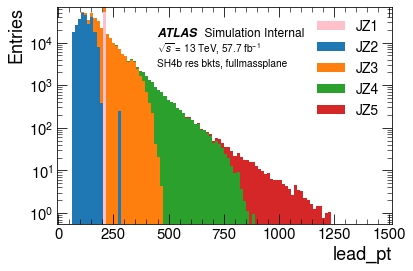

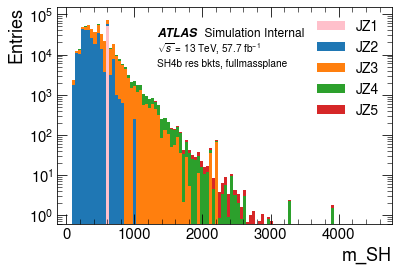

In [12]:
for col in ['lead_pt','m_SH']:
 
    plt.figure()
    plt.hist([jz1.loc[m1,col],jz2.loc[m2,col],jz3.loc[m3,col],jz4.loc[m4,col],jz5.loc[m5,col]],100,histtype='barstacked',
             label=['JZ1','JZ2','JZ3','JZ4','JZ5'],color=jz_colors,
             weights=[jz1.loc[m1,'mc_sf'],jz2.loc[m2,'mc_sf'],jz3.loc[m3,'mc_sf'],jz4.loc[m4,'mc_sf'],jz5.loc[m5,'mc_sf']])


    plt.legend()
    plt.xlabel(col,loc='right',fontsize=18)
    plt.ylabel('Entries',loc='top',fontsize=18)

    fig=plt.gcf()
    ax = plt.gca()
    
    pas.makeATLAStag(ax, fig, first_tag=' Simulation Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, 57.7 fb$^{-1}$"
                            +'\nSH4b res bkts, fullmassplane',
                 ymax=.85,xmin=.3,line_spacing=0.4,
                     fontsize_title=12,fontsize_label=10)

    
    
    plt.savefig(f'figures/QCD/{col}-jz1-5.pdf',bbox_inches='tight')
    
    plt.yscale('log')
    plt.savefig(f'figures/QCD/{col}-jz1-5-log.pdf',bbox_inches='tight')
    
    plt.show()

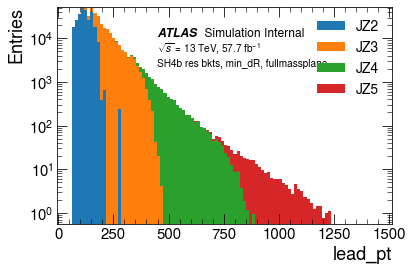

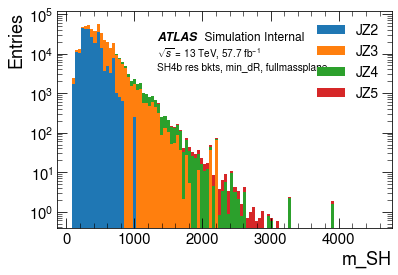

In [13]:
for col in ['lead_pt','m_SH']:
 
    plt.figure()
    plt.hist([jz2.loc[m2,col],jz3.loc[m3,col],jz4.loc[m4,col],jz5.loc[m5,col]],100,histtype='barstacked',
             label=['JZ2','JZ3','JZ4','JZ5'],
             weights=[jz2.loc[m2,'mc_sf'],jz3.loc[m3,'mc_sf'],jz4.loc[m4,'mc_sf'],jz5.loc[m5,'mc_sf']])


    plt.legend()
    plt.xlabel(col,loc='right',fontsize=18)
    plt.ylabel('Entries',loc='top',fontsize=18)

    fig=plt.gcf()
    ax = plt.gca()
    
    pas.makeATLAStag(ax, fig, first_tag=' Simulation Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, 57.7 fb$^{-1}$"
                            +'\nSH4b res bkts, min_dR, fullmassplane',
                 ymax=.85,xmin=.3,line_spacing=0.4,
                     fontsize_title=12,fontsize_label=10)

    
    
    plt.savefig(f'figures/QCD/{col}-jz2-5.pdf',bbox_inches='tight')
    
    plt.yscale('log')
    plt.savefig(f'figures/QCD/{col}-jz2-5-log.pdf',bbox_inches='tight')
    
    plt.show()

In [5]:
qcd = pd.concat([jz2, jz3, jz4,jz5])
qcd.reset_index(inplace=True)

jlist = [ak.zip( { k: qcd[f'j{i}_{v}'] for k,v in d.items()}, 
                with_name="PtEtaPhiELorentzVector") for i in range(4)]
hc_jets = ak.concatenate([j[:,None] for j in jlist],axis=1)

Cand1, Cand2 = do_min_dR_all(qcd,hc_jets)
defineCuts(qcd, Cand1, Cand2, 125, 170)

In [6]:
qcd.to_parquet('../data/qcd_jz2345_min_dR_all_4b_DL1d77_4b.parquet')

In [141]:
jz2.bucket.min(),jz2.bucket.max()

(2, 4)

In [142]:
%%bash
ls ../data/allhad_ttbar_mc20e-MAR23

df_min_dR_4b_DL1d77_4b.parquet
files


bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)


In [1]:
%%bash
ls ../data/JZ2_mc20e-MAR23/

df_min_dR_4b_DL1d77_4b.parquet
files


bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)


In [7]:
tt = pd.read_parquet('../data/allhad_ttbar_mc20e-MAR23/df_min_dR_4b_DL1d77_4b.parquet')
tt.reset_index(inplace=True)

jlist = [ak.zip( { k: tt[f'j{i}_{v}'] for k,v in d.items()}, 
                with_name="PtEtaPhiELorentzVector") for i in range(4)]
hc_jets = ak.concatenate([j[:,None] for j in jlist],axis=1)

Cand1, Cand2 = do_min_dR_all(tt,hc_jets)
defineCuts(tt, Cand1, Cand2, 125, 170)


In [8]:
qcd.to_parquet('../data/allhad_ttbar_min_dR_all_4b_DL1d77_4b.parquet')

In [8]:
tt.columns

Index(['index', 'pileupWeight', 'generatorWeight', 'eventNumber', 'runNumber',
       'HLT_j225_gsc300_bmv2c1070_split',
       'HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_2j45_gsc55_bmv2c1050_split_ht300_L1HT190_J15s5pETA21',
       'HLT_2j35_bmv2c1060_split_2j35_L14J15p0ETA25', 'mcEventWeight', 'njets',
       'ntag', 'lead_pt', 'third_pt', 'trigger', 'nr_bucket', 'lead_tag',
       'HT_all', 'bucket', 'X_wt_tag', 'mc_sf', 'chosenPair', 'm_SH', 'pt_SH',
       'pt_H', 'eta_H', 'phi_H', 'm_H', 'pt_S', 'eta_S', 'phi_S', 'm_S',
       'dEta_SH', 'X_SH', 'j0_pt', 'j0_eta', 'j0_phi', 'j0_E', 'j1_pt',
       'j1_eta', 'j1_phi', 'j1_E', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_E',
       'j3_pt', 'j3_eta', 'j3_phi', 'j3_E', 'dRjj_1', 'dRjj_2'],
      dtype='object')

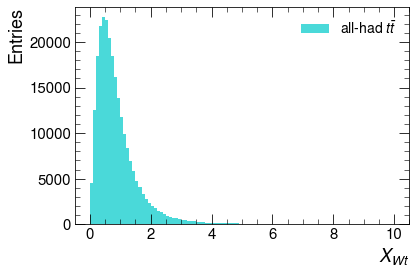

In [15]:
plt.hist(tt.X_wt_tag,100,(0,10),color='hh:lightturquoise',
         label=r'all-had $t\bar{t}$')
plt.xlabel('$X_{Wt}$',loc='right',fontsize=18)
plt.ylabel('Entries',loc='top',fontsize=18)
plt.legend()
plt.show()

**Fullmassplane**

In [17]:
e = np.array([ 280., 305., 333., 363., 395., 431., 470., 512., 
                      558., 608., 663., 723., 788., 858., 936., 1020.])

xx = 0.5 * (e[1:]+e[:-1])
w = e[1:] - e[:-1]

width = 7.75 
height = 5.92
bottom =0.11

elw = 2
epsilon = .001

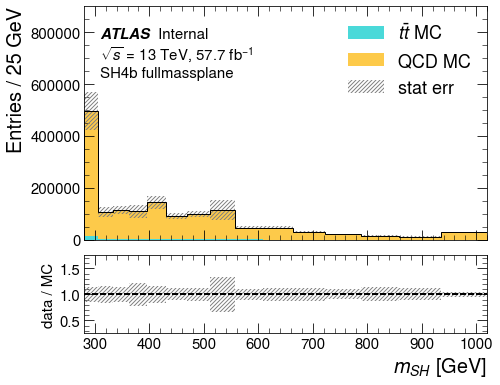

In [18]:
fig, [ax1,ax2] = plt.subplots(
            2,
            1,
            figsize=(7, 5.9),
            sharex=True,
            gridspec_kw={
                "height_ratios": [0.75, 0.25],
                "hspace": 0.1,
                "left": 0.1,
                "bottom": .11,
            },
        )

'''
Define the histograms
'''
v_tt = np.clip(tt['m_SH'], e[0]+epsilon, e[-1]-epsilon)
v_qcd = np.clip(qcd['m_SH'], e[0]+epsilon, e[-1]-epsilon)

h_tt = np.histogram(v_tt,e,weights=tt['mc_sf'])[0]

h_qcd = np.histogram(v_qcd,e, weights=qcd['mc_sf'])[0]

# add the combined background estimate
bkg = h_tt+h_qcd

# add an errorbar
dbkg = np.sqrt(np.histogram(np.append(v_tt,v_qcd),e,
                            weights=np.append(tt['mc_sf'], qcd['mc_sf'])**2)[0])

'''
Draw the histograms
'''
scale=25/w

ax1.hist(xx,e,label=r'$t\bar{t}$ MC', color='#4ad9d9', # lightturquoise
         weights=h_tt*scale)

ax1.hist(xx,e,label='QCD MC',color='#fdc536',alpha=.9, # darkyellow
         bottom=h_tt*scale, weights=h_qcd*scale)
ax1.hist(xx,e,weights=bkg*scale,histtype='step',color='k')

ax1.fill_between(e,
                 np.append((bkg+dbkg) * scale,[0]),
                 np.append((bkg-dbkg) * scale,[0]),
                 color='grey',step='post',
                 hatch='//////',
                 fc= "None",
                 edgecolor= "grey",
                 label='stat err',
                 lw= 0,
                 zorder=2
                )

# h_4b = np.histogram(np.clip(dat['m_hh'], e[0]+epsilon, e[-1]-epsilon),e)[0]

# ax1.errorbar(xx,h_4b*scale,np.sqrt(h_4b)*scale,w/2,lw=0,elinewidth=elw,
#              marker='o',color='k',label='4b data')


'''
Add the subpanel
'''

ax2.plot(e[[0,-1]],[1]*2,'k--')

ax2.fill_between(e,
                 np.append(1+dbkg/bkg,[0]),
                 np.append(1-dbkg/bkg,[0]),
                 color='grey',step='post',
                 hatch='//////',
                 fc= "None",
                 edgecolor= "grey",
                 lw= 0,
                 zorder=2
                )

# ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
#              lw=0,elinewidth=elw,
#              marker='o',color='k')

'''
Add annotations
'''
ax1.legend(fontsize=18)
ax1.set_ylabel('Entries / 25 GeV',loc='top',fontsize=20)
ax2.set_xlabel('$m_{SH}$ [GeV]',loc='right',fontsize=20)
ax2.set_ylabel('data / MC')

pas.makeATLAStag(ax1, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, 57.7 fb$^{-1}$"
                            +'\nSH4b fullmassplane',
                 ymax=.85,line_spacing=0.8)

ylim = ax1.get_ylim()
ax1.set_ylim(0,1.5*ylim[1])

ax2.set_xlim(e[[0,-1]])
ax2.set_ylim(.25,1.75)

plt.savefig('figures/m-hh-CR1-4b-MC.pdf',bbox_inches='tight')

In [19]:
from colors import *

## Step 0: Load in the data

-> Also... let's look at the massplanes!!

In [186]:
%%bash
ls ../data/data18-MAR23

df_min_dR_4b_DL1d77_4b.parquet
files


bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)


In [3]:
dat = pd.read_parquet('../data/data18-MAR23/df_min_dR_4b_DL1d77_4b.parquet')

In [21]:
dat.columns

Index(['eventNumber', 'runNumber', 'HLT_j225_gsc300_bmv2c1070_split',
       'HLT_j110_gsc150_boffperf_split_2j45_gsc55_bmv2c1070_split_L1J85_3J30',
       'HLT_2j45_gsc55_bmv2c1050_split_ht300_L1HT190_J15s5pETA21',
       'HLT_2j35_bmv2c1060_split_2j35_L14J15p0ETA25', 'njets', 'ntag',
       'lead_pt', 'third_pt', 'trigger', 'nr_bucket', 'lead_tag', 'HT_all',
       'bucket', 'X_wt_tag', 'chosenPair', 'm_SH', 'pt_SH', 'pt_H', 'eta_H',
       'phi_H', 'm_H', 'pt_S', 'eta_S', 'phi_S', 'm_S', 'dEta_SH', 'X_SH',
       'j0_pt', 'j0_eta', 'j0_phi', 'j0_E', 'j1_pt', 'j1_eta', 'j1_phi',
       'j1_E', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_E', 'j3_pt', 'j3_eta',
       'j3_phi', 'j3_E'],
      dtype='object')

In [22]:
nbins = 50
r = (25,225)

w = (r[1] - r[0]) / nbins
zlabel = f'Entries / ({int(w)} GeV)$^2$'

In [1]:
# os.sys.path.append('../easyjet-explore/')
from plotting import draw_bounding_box, draw_contours

NameError: name 'os' is not defined

In [24]:
mS_list = [70,100,170,200,300,400,500]
r_cr = 45
lw=2.5

In [25]:
kwargs = {'ls':'dotted',
          'lw':lw,
          'color':'hh:darkpink'
         }

In [26]:
from regions import *

In [27]:
mH = xi = 125

r_cr_x = 1.1 * (xi/.84 - xi /1.16)
print(r_cr_x)

xmin_i = xi - r_cr_x
xmax_i = xi + r_cr_x

res_x = 0.1 

sr_dict = { "fn": "shiftXhh",
            "fn_args": {"center_x": xi, "center_y": None, 
                        "res_x": res_x,"res_y": 0.1},
            "bound": 1.6,
            "lw": lw,
            "ls": "solid",
            "label": None,} 

45.15599343185552


In [28]:
from colors import *

In [29]:
mS_SRs = [75,102, 166, 193, 278, 363, 447]

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/plotting.py:68: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(


107.75862068965517
148.80952380952382


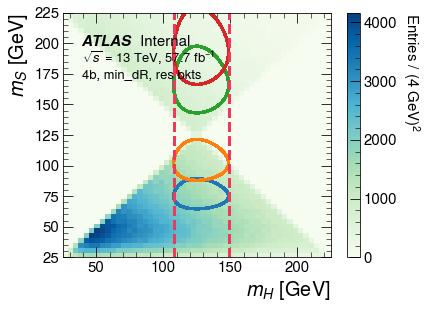

In [30]:
plt.figure(figsize=(6,4.5))

mask = (dat.dEta_SH < 1.5)

h_2d,ex,ey,_ = plt.hist2d(*dat[['m_H','m_S']].values.T, [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()


xi = 125

for i, mS in enumerate(mS_SRs):

    yi = mS
    color_i = f'C{i}'
    
    y_cr_i = yi*1.05
    ymin_i = y_cr_i - r_cr
    ymax_i = y_cr_i + r_cr

    sr_dict["fn_args"]["center_y"]= yi
    sr_dict['color'] = color_i
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])

    # draw_bounding_box(ax,xmin_i,xmax_i,ymin_i,ymax_i,kwargs)

plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,color='#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

# plt.savefig(f'figures/data18/fmp_min_dR_4b_all.png',bbox_inches='tight')
# plt.savefig(f'figures/data18/fmp_min_dR_4b_all.pdf',bbox_inches='tight')

plt.show()

Hmmmmm... this looks q odd. Did I fuck smth up?

This looks quite odd... Ack.

Nope, this is literally definitionally what chooseing the pair closer to the Higgs mass will do.

Just for comparison... I _also_ want to plot the min $\Delta m$ massplane!

In [7]:
# Reconstruct the 4 vectors
d = {'pt':'pt','eta':'eta','phi':'phi','energy':'E'}

j0 = ak.zip( { k: dat[f'j0_{v}'] for k,v in d.items()},  with_name="PtEtaPhiELorentzVector")
j1 = ak.zip( { k: dat[f'j1_{v}'] for k,v in d.items()},  with_name="PtEtaPhiELorentzVector")
j2 = ak.zip( { k: dat[f'j2_{v}'] for k,v in d.items()},  with_name="PtEtaPhiELorentzVector")
j3 = ak.zip( { k: dat[f'j3_{v}'] for k,v in d.items()},  with_name="PtEtaPhiELorentzVector")

hc_jets = ak.concatenate([j0[:,None],j1[:,None],j2[:,None],j3[:,None]],axis=1)

Little sanity check

In [8]:
X = hc_jets[:,0]+hc_jets[:,1]+hc_jets[:,2]+hc_jets[:,3]

In [9]:
np.sum(abs(X.mass.to_numpy() - dat.m_SH) > 1e-3)

104

In [10]:
dat['m_X'] = X.mass.to_numpy()

In [11]:
dat.loc[abs(X.mass.to_numpy() - dat.m_SH) > 1e-3,['m_SH','m_X']]

m_SH         m_X
2347  599.489380  599.488375
350   429.821198  429.819984
1422  719.044495  719.045853
1921  145.289368  145.290546
8534  518.242676  518.241659
...          ...         ...
449   189.182785  189.184110
5961  518.818848  518.817425
6687  457.517761  457.516394
4604  331.066467  331.067705
1878   99.916840   99.917843

[104 rows x 2 columns]

OK, i'll count this as a pass.

In [12]:
from analysis import do_min_dH, defineCuts

In [13]:
df_min_dH = dat[['X_wt_tag']].copy()

# Pair
HC, SC = do_min_dH(df_min_dH,hc_jets)

# Define the other cuts
defineCuts(df_min_dH, HC, SC, 125, 70)

In [14]:
plt.figure(figsize=(6,4.5))

mask = (dat.dEta_SH < 1.5)

h_2d,ex,ey,_ = plt.hist2d(*df_min_dH[['m_H','m_S']].values.T, [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()

for i, mS in enumerate(mS_SRs):

    yi = mS
    color_i = f'C{i}'
    
    sr_dict["fn_args"]["center_y"]= yi
    sr_dict['color'] = color_i
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])


plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dH, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

# plt.savefig(f'figures/data18/fmp_min_dH_4b_all.png',bbox_inches='tight')
# plt.savefig(f'figures/data18/fmp_min_dH_4b_all.pdf',bbox_inches='tight')

plt.show()

NameError: name 'nbins' is not defined

<Figure size 432x324 with 0 Axes>

Amazing... OK, I think this is just an artifact of the definition of the algorithm... I don't think that it's a bug.

In the `Ordering` nb, I explored some other baseline pairing algorithms, so I'll just sanity check what these do for the massplane.

**min_dR_lead**

The pairing stays the same, just the assignment of the scalar and Higgs candidates change.

In [ ]:
dat.columns

In [ ]:
from analysis import dr_lead

In [ ]:
def do_min_dR_lead(evts,hc_jets):
    '''
    Goal: Do the baseline analysis selection.

    Inputs:
    - evts
    - hc_jets
    '''

    evts['chosenPair'] = np.argmin( np.vstack([dr_lead(hc_jets, i) for i in range(3)]), axis=0)    

    
    ja0 = hc_jets[:,0]
    print('chosen pair',np.unique(evts['chosenPair'].values.astype(int)))
    
    ja1 = hc_jets[range(len(hc_jets)),evts['chosenPair'].values.astype(int)+1]

    jb0 = ak.where(evts['chosenPair']==0, hc_jets[:,2], hc_jets[:,1])
    jb1 = ak.where(evts['chosenPair']==2, hc_jets[:,2], hc_jets[:,3])

    hca = ja0+ja1
    hcb = jb0+jb1
      
    dRa = ja0.delta_r(ja1)
    dRb = jb0.delta_r(jb1)
    
    # NOTATION: Let "1" be the di-jet pair with the _smaller_ opening angle
    sort_mask = dRa < dRb
    Cand1 = ak.where(sort_mask, hca, hcb)
    Cand2 = ak.where(sort_mask, hcb, hca)

    # There are more possibilities for pairing in SH events (6 possibile pairings instead of 3).
    # In truth.py, correctPair = {0,1,2} if j0 is in the Higgs candidate, 
    # and {3,4,5} if j0 is in the S candidate
#     evts.loc[~sort_mask.to_numpy(),'chosenPair'] += 3
#     print('chosen pair: extended labelling',np.unique(evts['chosenPair'].values.astype(int),return_counts=True))
    
    return Cand1, Cand2


In [ ]:
df_lead = dat[['X_wt_tag']].copy()

# Pair
Cand1, Cand2 = do_min_dR_lead(df_lead,hc_jets)

# Define the other cuts
defineCuts(df_lead, Cand1, Cand2, 125, mS_list[0])

In [ ]:
sr_dict

For $m_S < m_H$, then S has the smaller $\Delta R(bb)$

In [ ]:
plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_lead[['m_S','m_H']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()

for i, mS in enumerate(mS_SRs):
    
    if mS > mH:
        break
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])


plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_lead, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'hh:darkpink',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_lead_4b_small_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_lead_4b_small_mS.pdf',bbox_inches='tight')

plt.show()

For $m_S$ > $m_H$, the smaller $\Delta R$ is the ...

In [ ]:
nbins

In [ ]:
plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_lead[['m_H','m_S']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu') #,norm=LogNorm())

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()


for i, mS in enumerate(mS_SRs):
    
    if mS < mH:
        continue
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])


plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_lead, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'hh:darkpink',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_lead_4b_large_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_lead_4b_large_mS.pdf',bbox_inches='tight')

plt.show()

OK, nice!

**min_dR_all**

In [15]:
df_all = dat.copy() # [['X_wt_tag']]
df_all.reset_index(inplace=True)

# Pair
Cand1, Cand2 = do_min_dR_all(df_all,hc_jets)

# Define the other cuts
defineCuts(df_all, Cand1, Cand2, 125, 70)

In [16]:
df_all.to_parquet('../data/data18_min_dR_all_4b_DL1d77_4b.parquet')

$m_S < m_H$, the smaller dR is the scalar

107.75862068965517
148.80952380952382


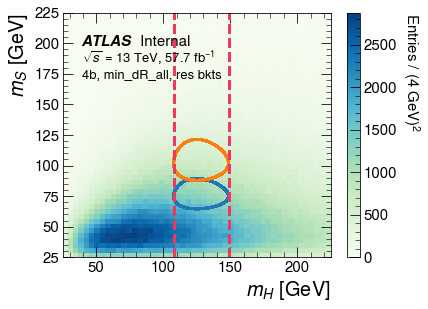

In [48]:
plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_all[['m_S','m_H']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()

for i, mS in enumerate(mS_SRs):
    
    if mS > mH:
        break
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])



plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_all_4b_small_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_all_4b_small_mS.pdf',bbox_inches='tight')

plt.show()

$m_S < m_H$, the smaller dR is the Higgs

In [49]:
from matplotlib.colors import LogNorm

107.75862068965517
148.80952380952382


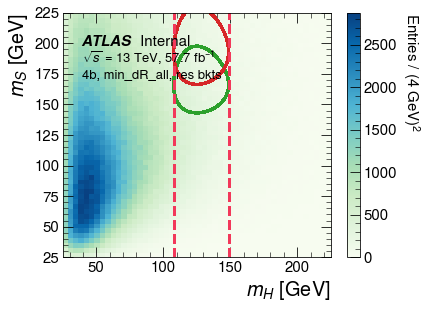

In [50]:
plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_all[['m_H','m_S']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu') #,norm=LogNorm())

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()
for i, mS in enumerate(mS_SRs):
    
    if mS < mH:
        continue
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])

plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, res bkts',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_all_4b_large_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_all_4b_large_mS.pdf',bbox_inches='tight')

plt.show()

When I super zoom out on the S axis and use a log scale, the counts get _small_ but they're *still* non-zero!

**Plan:** Also show the data after the $\Delta \eta_{SH}$ and $X_{Wt}$ cuts.

107.75862068965517
148.80952380952382


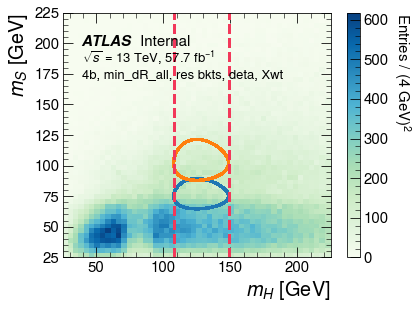

In [51]:
mask = (df_all.dEta_SH < 1.5) & (df_all.X_wt_tag > 1.5)

plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_all.loc[mask,['m_S','m_H']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu')

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()

for i, mS in enumerate(mS_SRs):
    
    if mS > mH:
        break
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])



plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, res bkts, deta, Xwt',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_all_Xwt_cut_4b_small_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_all_Xwt_cut_4b_small_mS.pdf',bbox_inches='tight')

plt.show()


/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/plotting.py:68: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(


107.75862068965517
148.80952380952382


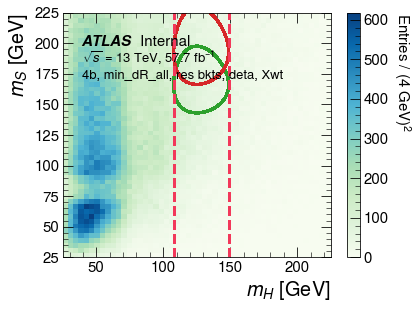

In [52]:
plt.figure(figsize=(6,4.5))

h_2d,ex,ey,_ = plt.hist2d(*df_all.loc[mask,['m_H','m_S']].values.T, 
                          [nbins,nbins],[r,r], cmap='GnBu') #,norm=LogNorm())

cbar = plt.colorbar()

# Draw the SR + the rw
fig,ax = plt.gcf(), plt.gca()
for i, mS in enumerate(mS_SRs):
    
    if mS < mH:
        continue
    
    sr_dict["fn_args"]["center_y"]= mS
    sr_dict['color'] = f'C{i}'
    
    draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])

plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, res bkts, deta, Xwt',
                 ymax=.85,xmin=.07,line_spacing=.3,
                 fontsize_title=15,fontsize_label=13)   


# Put the SR boundaries on the plot
for b in [125/1.16, 125/.84]:
    print(b)
    plt.plot([b]*2,r,'#f2385a',ls='--',lw=2.5)

plt.xlim(r)
plt.ylim(r)

plt.savefig(f'figures/data18/fmp_min_dR_all_Xwt_cut_4b_large_mS.png',bbox_inches='tight')
plt.savefig(f'figures/data18/fmp_min_dR_all_Xwt_cut_4b_large_mS.pdf',bbox_inches='tight')

plt.show()

## Step 1: C.f. data in the CRs

Maybe the "baby step" could just be looking at the marginals for the low and high mass side bands??



(0.25, 1.75)

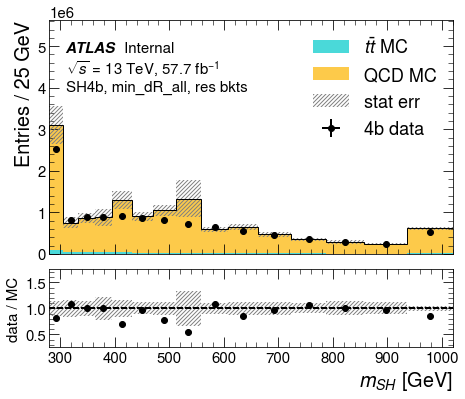

In [54]:
fig, [ax1,ax2] = plt.subplots(
            2,
            1,
            figsize=(7, 5.9),
            sharex=True,
            gridspec_kw={
                "height_ratios": [0.75, 0.25],
                "hspace": 0.1,
                "left": 0.1,
                "bottom": .11,
            },
        )

'''
Define the histograms
'''
v_tt = np.clip(tt['m_SH'], e[0]+epsilon, e[-1]-epsilon)
v_qcd = np.clip(qcd['m_SH'], e[0]+epsilon, e[-1]-epsilon)

h_tt = np.histogram(v_tt,e,weights=tt['mc_sf'])[0]

h_qcd = np.histogram(v_qcd,e, weights=qcd['mc_sf'])[0]

# add the combined background estimate
bkg = h_tt+h_qcd

# add an errorbar
dbkg = np.sqrt(np.histogram(np.append(v_tt,v_qcd),e,
                            weights=np.append(tt['mc_sf'], qcd['mc_sf'])**2)[0])

'''
Draw the histograms
'''
scale=25/w

ax1.hist(xx,e,label=r'$t\bar{t}$ MC', color='#4ad9d9', # lightturquoise
         weights=h_tt*scale)

ax1.hist(xx,e,label='QCD MC',color='#fdc536',alpha=.9, # darkyellow
         bottom=h_tt*scale, weights=h_qcd*scale)
ax1.hist(xx,e,weights=bkg*scale,histtype='step',color='k')

ax1.fill_between(e,
                 np.append((bkg+dbkg) * scale,[0]),
                 np.append((bkg-dbkg) * scale,[0]),
                 color='grey',step='post',
                 hatch='//////',
                 fc= "None",
                 edgecolor= "grey",
                 label='stat err',
                 lw= 0,
                 zorder=2
                )

h_4b = np.histogram(np.clip(dat['m_SH'], e[0]+epsilon, e[-1]-epsilon),e)[0]

ax1.errorbar(xx,h_4b*scale,np.sqrt(h_4b)*scale,w/2,lw=0,elinewidth=elw,
             marker='o',color='k',label='4b data')


'''
Add the subpanel
'''

ax2.plot(e[[0,-1]],[1]*2,'k--')

ax2.fill_between(e,
                 np.append(1+dbkg/bkg,[0]),
                 np.append(1-dbkg/bkg,[0]),
                 color='grey',step='post',
                 hatch='//////',
                 fc= "None",
                 edgecolor= "grey",
                 lw= 0,
                 zorder=2
                )

ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
             lw=0,elinewidth=elw,
             marker='o',color='k')

'''
Add annotations
'''
ax1.legend(fontsize=18)
ax1.set_ylabel('Entries / 25 GeV',loc='top',fontsize=20)
ax2.set_xlabel('$m_{SH}$ [GeV]',loc='right',fontsize=20)
ax2.set_ylabel('data / MC')

pas.makeATLAStag(ax1, fig, first_tag=' Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, 57.7 fb$^{-1}$"
                             +'\nSH4b, min_dR_all, res bkts',
                 ymax=.85,line_spacing=0.8)

ylim = ax1.get_ylim()
ax1.set_ylim(0,1.5*ylim[1])

ax2.set_xlim(e[[0,-1]])
ax2.set_ylim(.25,1.75)

# plt.savefig('figures/dat18/m-hh-noCuts-4b-MC.pdf',bbox_inches='tight')

This is crazy the agreement is so good! I believe the _open question_ is whether the agreement gets _better_ or _worse_ when we impose more cuts?

**lowS-lowH sideband** 

Woah! This agreement is really great!!

Alright... back to some CRs!

I'll functionify the plotting function, and go from there!


In [64]:
import operator as SmoothOperator
from trigger import offline_mask
from itertools import product

In [80]:
cols = [f'{tag}-mass SB: {regn}' for tag,regn in product(['low','high'],['CR','SR'])]
datOverMC     = pd.DataFrame(0,mS_SRs,cols)
datOverMC_err = pd.DataFrame(0,mS_SRs,cols)

In [144]:
def dataMCCompare(dat, qcd, tt, cuts, col='m_SH',e=None,
                  xlabel=None,
                  second_tag= r"$\sqrt{s}$ = 13 TeV, SH4b",
                  ref_val=-1,
                  figDir='',tag=''):
    '''
    Goal: Look at a MC prediction, and compare to the data prediction.
    
    Inputs:
    - dat: df for the data
    - qcd: df for the QCD MC
    - tt: df for the ttbar MC
    - cuts: dictionary for the 
    - col: The column to plot
    - e: The bin edges, if None (default) will be inferred automatically
    - ref_val: If -1, what to norm the hist scale to (for var width bins)
    - figDir: Dir to save the fig in (only saves when this is _not_ an empty string)
    - tag: Tag to append to the figname 
    
    Under / overflow is taken care of automatically
    '''
 
    # Sanity check that cuts has the right keys
    assert ('offVar' in cuts) and ('offVarCut' in cuts) and ('operator' in cuts)

    '''
    Define the masks
    '''
    m_dat = offline_mask(dat,cuts)
    m_qcd = offline_mask(qcd,cuts)
    m_tt = offline_mask(tt,cuts)
    
    '''
    Define the histograms
    '''
    eps = .001
    
    v_tt  = np.clip(tt.loc[m_tt,col], e[0]+eps, e[-1]-eps)
    v_qcd = np.clip(qcd.loc[m_qcd,col], e[0]+eps, e[-1]-eps)
    
    if e is None:
        hmin = np.min(np.append(v_tt,v_qcd))
        hmax = np.max(np.append(v_tt,v_qcd))
        e = np.linspace(hmin,hmax,26)
    
    h_tt = np.histogram(v_tt,e,weights=tt.loc[m_tt,'mc_sf'])[0]

    h_qcd = np.histogram(v_qcd,e, 
                         weights=qcd.loc[m_qcd,'mc_sf'])[0]

    # add the combined background estimate
    bkg = h_tt+h_qcd

    # add an errorbar
    ws = np.append(tt.loc[m_tt,'mc_sf'], qcd.loc[m_qcd,'mc_sf'])
    dbkg = np.sqrt(np.histogram(np.append(v_tt,v_qcd), e,
                                weights=ws**2)[0])
    
    
    h_4b = np.histogram(np.clip(dat.loc[m_dat,col], e[0]+epsilon, e[-1]-epsilon),e)[0]
    
    # Print the yields
    d = np.sum(h_4b)
    dd = np.sqrt(d)
    
    b = np.sum(ws)
    db = np.sqrt(np.sum(ws**2))
    ratio = d/b
    ratio_err = abs((b*dd- d*db)/b**2)
    
    print(f'dat = {d:.0f}+-{dd:.0f}, mc = {b:.0f}+-{db:.0f}')
    print(f'dat / mc = {ratio:.4f}+-{ratio_err:.4f}')

    text = f'dat/mc={ratio:.2f}$\pm${ratio_err:.2f}'
    
    '''
    Draw the histograms
    '''
    xx = 0.5 * (e[1:]+e[:-1])
    w = e[1:] - e[:-1]
    elw = 2
    
    if ref_val != -1:
        scale=ref_val/w
        ylabel=f'Entries / {ref_val} GeV' 
    else:
        scale = 1
        ylabel='Entries'

    fig, [ax1,ax2] = plt.subplots(
            2,
            1,
            figsize=(7, 5.9),
            sharex=True,
            gridspec_kw={
                "height_ratios": [0.75, 0.25],
                "hspace": 0.1,
                "left": 0.1,
                "bottom": .11,
            },
        )
    
    ax1.hist(xx,e,label=r'$t\bar{t}$ MC', color='#4ad9d9', # lightturquoise
             weights=h_tt*scale)

    ax1.hist(xx,e,label='QCD MC',color='#fdc536',alpha=.9, # darkyellow
             bottom=h_tt*scale, weights=h_qcd*scale)
    ax1.hist(xx,e,weights=bkg*scale,histtype='step',color='k')

    ax1.fill_between(e,
                     np.append((bkg+dbkg) * scale,[0]),
                     np.append((bkg-dbkg) * scale,[0]),
                     color='grey',step='post',
                     hatch='//////',
                     fc= "None",
                     edgecolor= "grey",
                     label='stat err',
                     lw= 0,
                     zorder=2
                    )


    ax1.errorbar(xx,h_4b*scale,np.sqrt(h_4b)*scale,w/2,lw=0,elinewidth=elw,
                 marker='o',color='k',label='4b data')


    '''
    Add the subpanel
    '''

    ax2.plot(e[[0,-1]],[1]*2,'k--')

    ax2.fill_between(e,
                     np.append(1+dbkg/bkg,[0]),
                     np.append(1-dbkg/bkg,[0]),
                     color='grey',step='post',
                     hatch='//////',
                     fc= "None",
                     edgecolor= "grey",
                     lw= 0,
                     zorder=2
                    )

    ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
                 lw=0,elinewidth=elw,
                 marker='o',color='k')

    '''
    Add annotations
    '''
    
    ax1.text(.98,.25,text,transform=ax1.transAxes,ha='right',va='bottom',fontsize=18)
    
    
    ax1.legend(loc='upper right',fontsize=18)
    ax1.set_ylabel(ylabel,loc='top',fontsize=20)
    ax2.set_xlabel(col if xlabel is None else xlabel,loc='right',fontsize=20)
    ax2.set_ylabel('data / MC')

    pas.makeATLAStag(ax1, fig, first_tag=' Internal',
                     second_tag=second_tag,
                     ymax=.85,line_spacing=0.8)

    ylim = ax1.get_ylim()
    ax1.set_ylim(0,1.5*ylim[1])

    ax2.set_xlim(e[[0,-1]])
    ax2.set_ylim(.25,1.75)

    if figDir:
        plt.savefig(f'{figDir}/{col}{tag}.pdf',bbox_inches='tight')
        
    return ratio, ratio_err

In [82]:
cols = ['m_SH']
es = [e,]


xlabel = '$m_{SH}$ [GeV]'

dat = 96087+-310, mc = 145648+-23550
dat / mc = 0.6597+-0.1045


(0.6597198471831309, 0.10454069735346253)

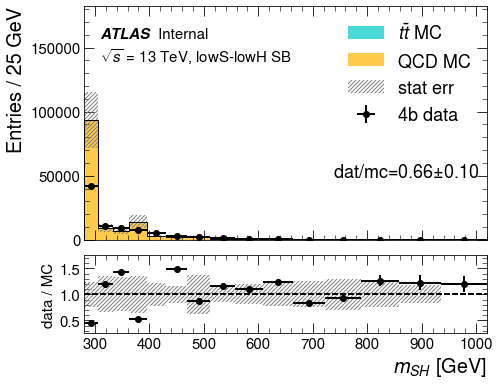

In [83]:
'''
NOTE: This is _not_ a type-O. For the low mass sideband, the Higgs and S labels are
_flipped_
'''

second_tag = r"$\sqrt{s}$ = 13 TeV, lowS-lowH SB"

cuts = {
    "offVar": ["dEta_SH", "X_wt_tag","m_S","m_H"],
    "offVarCut": [1.5, 1.5, 107.8, 125 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt,SmoothOperator.lt],
    }

figDir = 'figures/data18/lowS-lowH'
if not os.path.exists(figDir):
    os.mkdir(figDir)

dataMCCompare(df_all, qcd, tt, cuts, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,xlabel=xlabel,figDir=figDir)

**lowS-highH sideband** 

dat = 194595+-441, mc = 210870+-15981
dat / mc = 0.9228+-0.0678


(0.9228179689154461, 0.06784363441864928)

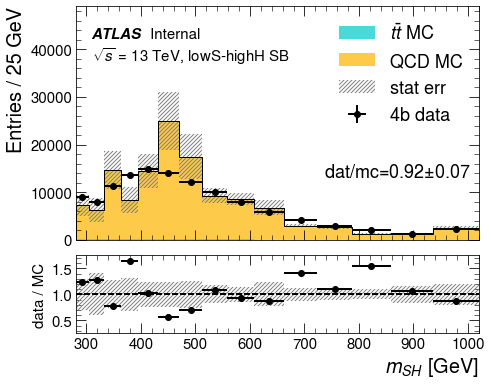

In [84]:
'''
NOTE: This is _not_ a type-O. For the low mass sideband, the Higgs and S labels are
_flipped_
'''

second_tag = r"$\sqrt{s}$ = 13 TeV, lowS-highH SB"

cuts = {
    "offVar": ["dEta_SH", "X_wt_tag","m_S","m_H"],
    "offVarCut": [1.5, 1.5, 148.8, 125 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,SmoothOperator.lt],
    }

figDir = 'figures/data18/lowS-highH'
if not os.path.exists(figDir):
    os.mkdir(figDir)

dataMCCompare(df_all, qcd, tt, cuts, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,xlabel=xlabel,figDir=figDir)

**highS-lowH sideband** 

dat = 207568+-456, mc = 237844+-19799
dat / mc = 0.8727+-0.0707


(0.8727064798775668, 0.07073342840558965)

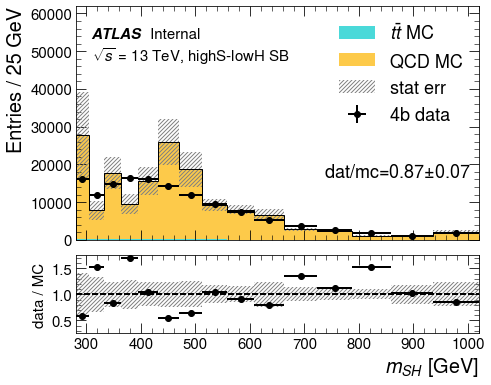

In [85]:
second_tag = r"$\sqrt{s}$ = 13 TeV, highS-lowH SB"

cuts = {
    "offVar": ["dEta_SH", "X_wt_tag","m_H","m_S"],
    "offVarCut": [1.5, 1.5, 107.8, 125 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt,SmoothOperator.gt],
    }

figDir = 'figures/data18/highS-lowH'
if not os.path.exists(figDir):
    os.mkdir(figDir)

dataMCCompare(df_all, qcd, tt, cuts, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,xlabel=xlabel,figDir=figDir)

**highS-highH sideband** 

dat = 30697+-175, mc = 39211+-7060
dat / mc = 0.7829+-0.1365


<ipython-input-81-aef965d7ae7c>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-81-aef965d7ae7c>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-81-aef965d7ae7c>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-81-aef965d7ae7c>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


(0.782860033556131, 0.1364871564494389)

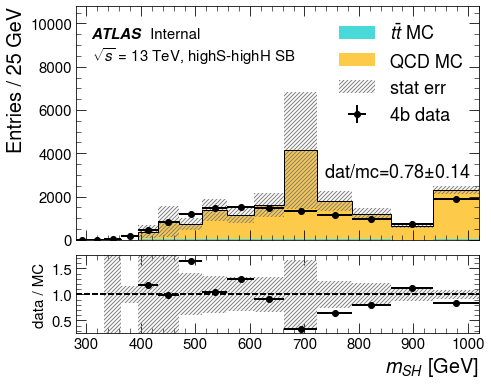

In [86]:
second_tag = r"$\sqrt{s}$ = 13 TeV, highS-highH SB"

cuts = {
    "offVar": ["dEta_SH", "X_wt_tag","m_H","m_S"],
    "offVarCut": [1.5, 1.5, 148.8, 125 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,SmoothOperator.gt],
    }

figDir = 'figures/data18/highS-highH'
if not os.path.exists(figDir):
    os.mkdir(figDir)

dataMCCompare(df_all, qcd, tt, cuts, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,xlabel=xlabel,figDir=figDir)

OK, these are very high stat error... but seems like enough to get a jist.

### Next: Go through the sidebands for each SR choice.

**First, for $m_S$ < $m_H$.** 
- This has the S with the closer $b$-jets

In [2]:
x = 70
x*(1/(1-.16*125/x) - 1/(1+.16*125/x))

12.645520259929947

In [3]:
x = 170
x*(1/(1-.16*125/x) - 1/(1+.16*x/125))

77.66124112874837

In [87]:
xi

125

In [88]:
r_cr_x

45.15599343185552

In [169]:
for df in [qcd,tt,df_all]:
    df['m_1'] = df['m_S']
    df['m_2'] = df['m_H'] 
     

**Sanity check:** Let's just look at the proposed SRs

In [170]:
ri = (0,300)
nb = 60

In [171]:
mask = (df_all.dEta_SH < 1.5) & (df_all.X_wt_tag > 1.5)

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


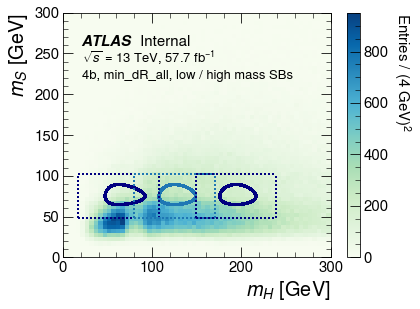

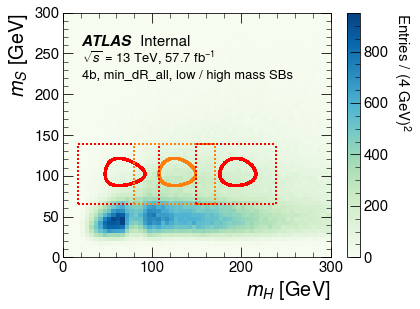

In [172]:
for i_SR, (mS_SR, c_SB) in enumerate(zip([75,102],['navy','red'])):

    plt.figure(figsize=(6,4.5))

    h_2d,ex,ey,_ = plt.hist2d(*df_all.loc[mask,['m_1','m_2']].values.T,
                              [nb,nb],[ri,ri], cmap='GnBu')

    cbar = plt.colorbar()

    # Draw the SR + the rw
    fig,ax = plt.gcf(), plt.gca()

    for i, mH_i in enumerate([125/1.16-r_cr_x, xi, 125/.84+r_cr_x]):

        sr_dict["fn_args"]["center_x"]= mH_i
        sr_dict["fn_args"]["res_x"]= 0.1 * xi / mH_i

        sr_dict["fn_args"]["center_y"]= mS_SR
        sr_dict["fn_args"]["res_y"]= 0.1 
        sr_dict['color'] = f'C{i_SR}' if i == 1 else c_SB

        yi = mS_SR
        r_cr_y = 1.1 * (yi / .84 - yi / 1.16)
        ymin = yi - r_cr_y
        ymax = yi + r_cr_y

        draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])
        draw_bounding_box(ax,mH_i - r_cr_x, mH_i + r_cr_x, ymin,ymax, 
                          kwargs={'ls':'dotted', 'lw':1.5, 'color':sr_dict['color']})


    plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
    plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

    cbar.set_label(zlabel,rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, low / high mass SBs',
                     ymax=.85,xmin=.07,line_spacing=.3,
                     fontsize_title=15,fontsize_label=13)   

    plt.xlim(ri)
    plt.ylim(ri)

    figDir = f'figures/data18/mS{mS_SR}-SBs'
    if not os.path.exists(figDir):
        os.mkdir(figDir)

    plt.savefig(f'{figDir}/fmp-low-high-mass-SBs.png',bbox_inches='tight')
    plt.savefig(f'{figDir}/fmp-low-high-mass-SBs.pdf',bbox_inches='tight')

    plt.show()

In [173]:
cols

['m_SH']

dat = 7841+-89, mc = 7825+-2271
dat / mc = 1.0020+-0.2795
dat = 43240+-208, mc = 65826+-17460
dat / mc = 0.6569+-0.1711
dat = 51081+-226, mc = 73652+-17607
dat / mc = 0.6935+-0.1627
dat = 6955+-83, mc = 8590+-4353
dat / mc = 0.8096+-0.4006
dat = 46896+-217, mc = 43333+-6741
dat / mc = 1.0822+-0.1634
dat = 53851+-232, mc = 51923+-8025
dat / mc = 1.0371+-0.1558


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 3776+-61, mc = 3123+-1209
dat / mc = 1.2089+-0.4481
dat = 23691+-154, mc = 27828+-6697
dat / mc = 0.8513+-0.1993
dat = 27467+-166, mc = 30951+-6805
dat / mc = 0.8874+-0.1898
dat = 6972+-83, mc = 3623+-501
dat / mc = 1.9242+-0.2431


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 37823+-194, mc = 35127+-6574
dat / mc = 1.0768+-0.1960
dat = 44795+-212, mc = 38750+-6593
dat / mc = 1.1560+-0.1912


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


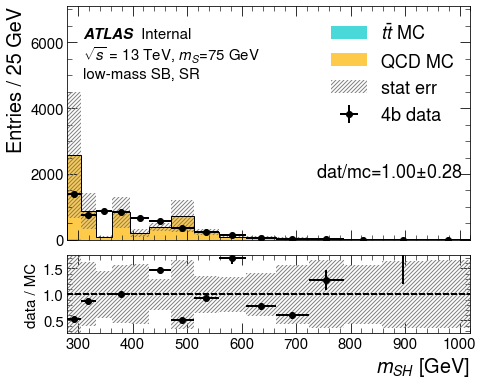

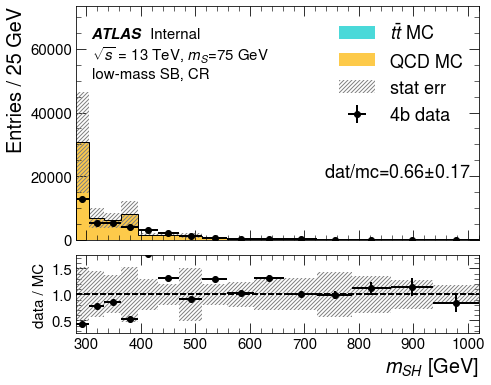

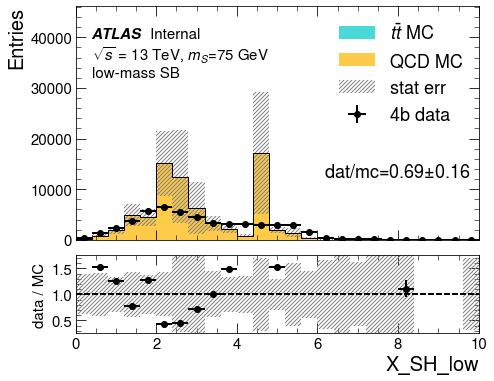

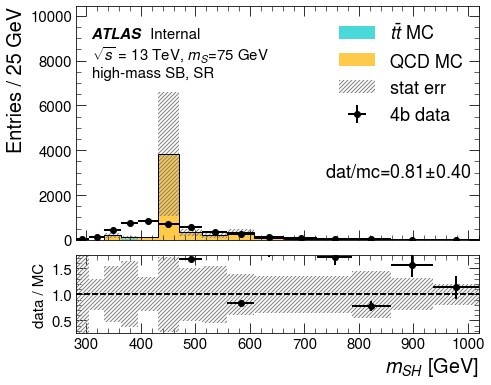

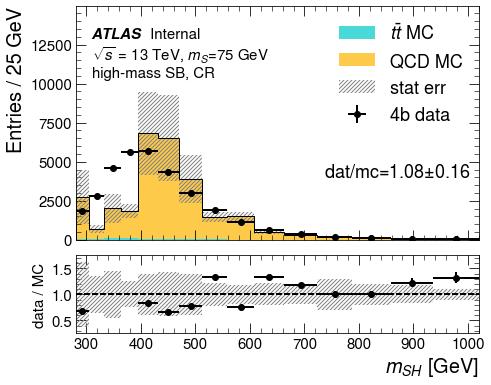

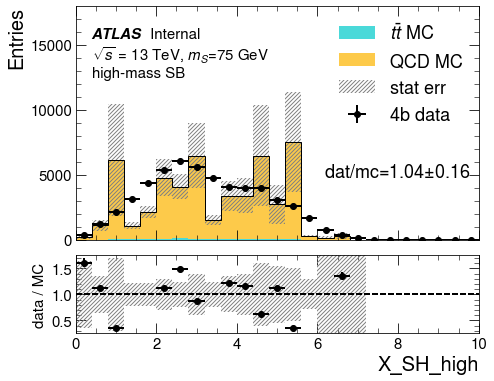

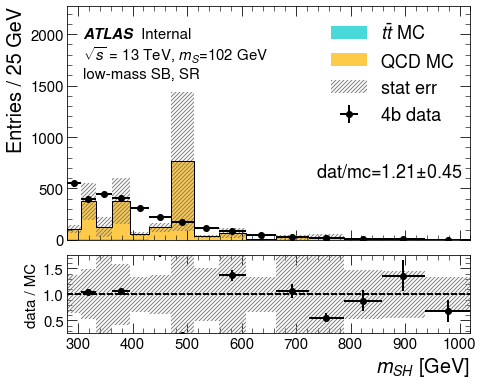

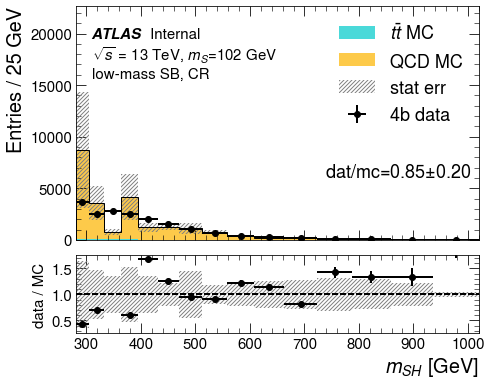

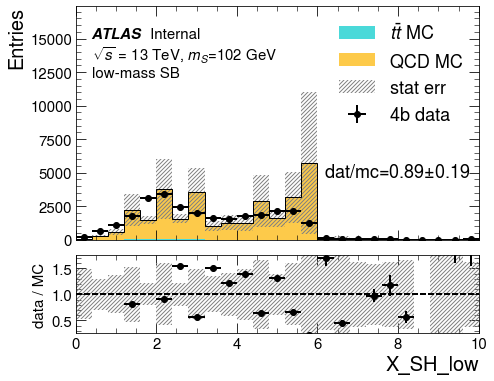

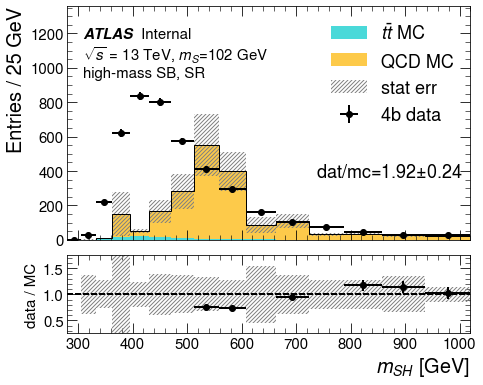

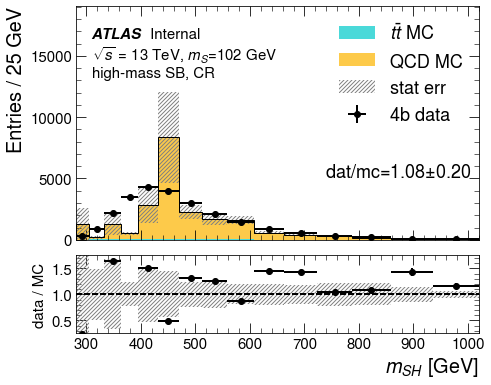

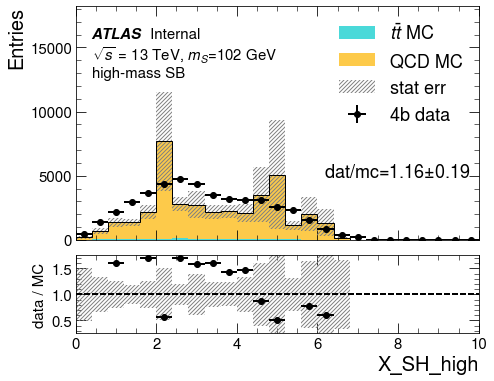

In [174]:
for i,mS_SR in enumerate([75,102]):
    
    # Redefine X_SH            
    xi_low = 125/1.16-r_cr_x
    xi_high = 125/.84+r_cr_x
    
    for df in [qcd,tt,df_all]:
        
        df['X_SH_low']  = getXhh(df['m_1'],df['m_2'],xi_low,mS_SR,res1=0.1*125/xi_low)
        df['X_SH_high'] = getXhh(df['m_1'],df['m_2'],xi_high,mS_SR,res1=0.1*125/xi_high)
    
    figDir = f'figures/data18/mS{mS_SR}-SBs'
    
    for tag, mH_i in zip(['low','high'], [xi_low,xi_high]):
        
        X_SH_col = f"X_SH_{tag}"
        
        cuts_SR = {
            "offVar": ["dEta_SH", "X_wt_tag",X_SH_col],
            "offVarCut": [1.5, 1.5, 1.6 ],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt],
            }

        second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV\n{tag}-mass SB"
        v,dv = dataMCCompare(df_all,qcd, tt, cuts_SR, col='m_SH', e=e,ref_val=25,
                      second_tag=second_tag+", SR",
                      xlabel=xlabel,figDir=figDir,tag=f'-{tag}-mass-SB-SR')

        datOverMC.loc[    mS_SR,f'{tag}-mass SB: SR'] = v
        datOverMC_err.loc[mS_SR,f'{tag}-mass SB: SR'] = dv

        xmin_i = mH_i - r_cr_x
        xmax_i = mH_i + r_cr_x
                      
        yi = mS_SR
        r_cr_y =  1.1* (yi/0.84 - yi/1.16)

        cuts_CR = {
            "offVar": ["dEta_SH", "X_wt_tag",X_SH_col, "m_1","m_1","m_2","m_2"],
            "offVarCut": [1.5, 1.5, 1.6, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,
                         SmoothOperator.gt, SmoothOperator.lt,
                         SmoothOperator.gt, SmoothOperator.lt,
                        ],
            }

        v,dv = dataMCCompare(df_all,qcd, tt, cuts_CR, col='m_SH', e=e,ref_val=25,
                      second_tag=second_tag+", CR",
                      xlabel=xlabel,figDir=figDir,tag=f'-{tag}-mass-SB-CR')
    
        datOverMC.loc[    mS_SR,f'{tag}-mass SB: CR'] = v
        datOverMC_err.loc[mS_SR,f'{tag}-mass SB: CR'] = dv
        
        
        '''
        Look at the X_SH modelling
        '''
        cuts_BB = {
            "offVar": ["dEta_SH", "X_wt_tag","m_1","m_1","m_2","m_2"],
            "offVarCut": [1.5, 1.5, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,
                         SmoothOperator.gt, SmoothOperator.lt,
                         SmoothOperator.gt, SmoothOperator.lt,
                        ],
            }

        v,dv = dataMCCompare(df_all,qcd, tt, cuts_BB, col=X_SH_col, 
                             e=np.linspace(0,10,26),second_tag=second_tag,
                             xlabel=X_SH_col,figDir=figDir,tag=f'-{tag}-mass-SB')

**Second, for $m_S$ < $m_H$.** 

In [95]:
for df in [qcd,tt,df_all]:
    df['m_1'] = df['m_H']
    df['m_2'] = df['m_S'] 
    

/gpfs/slac/atlas/fs1/d/nhartman/SH4b/easyjet-explore/../RRevolution/code/regions.py:24: RuntimeWarning: divide by zero encountered in true_divide
  ((m1 - center_x) / (res_x * m1)) ** 2 + ((m2 - center_y) / (res_y * m2)) ** 2


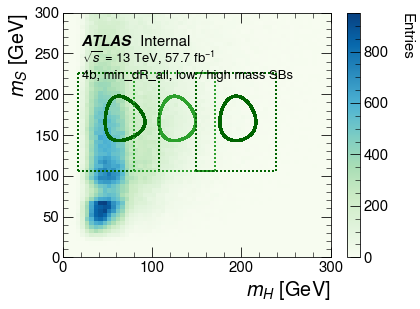

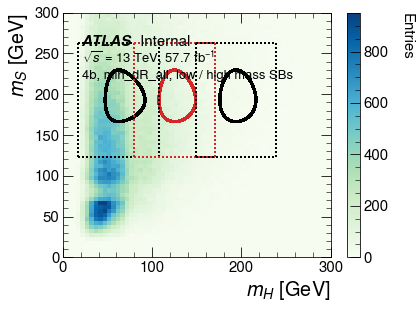

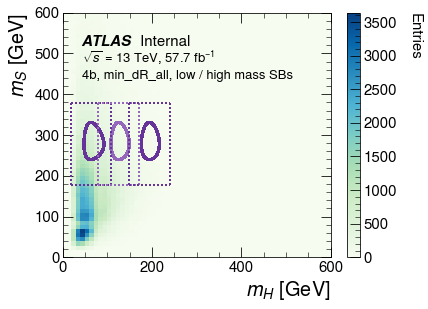

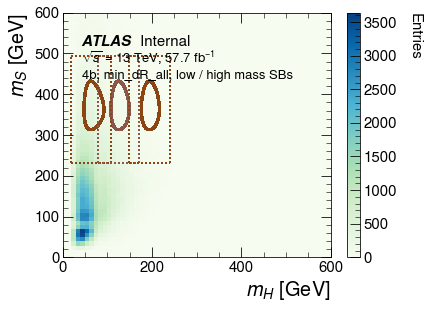

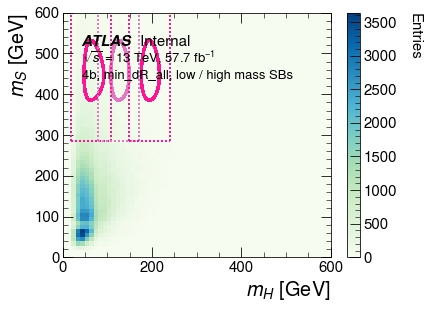

In [96]:
for i_SR,mS_SR,c_SB in zip([2,3,4,5,6],[166,193,278,363,447],['darkgreen','k','rebeccapurple','saddlebrown','deeppink']):
    
    plt.figure(figsize=(6,4.5))

    rx = ri if mS_SR < 200 else (0,600)
    
    h_2d,ex,ey,_ = plt.hist2d(*df_all.loc[mask,['m_1','m_2']].values.T,
                              [nb,nb],[rx,rx], cmap='GnBu')

    cbar = plt.colorbar()

    # Draw the SR + the rw
    fig,ax = plt.gcf(), plt.gca()

    for i, mH_i in enumerate([125/1.16-r_cr_x, xi, 125/.84+r_cr_x]):

        sr_dict["fn_args"]["center_x"]= mH_i
        sr_dict["fn_args"]["res_x"]= 0.1 * xi / mH_i

        sr_dict["fn_args"]["center_y"]= mS_SR
        sr_dict["fn_args"]["res_y"]= 0.1 
        sr_dict['color'] = f'C{i_SR}' if i == 1 else c_SB

        yi = mS_SR
        r_cr_y = 1.1 * (yi / .84 - yi / 1.16)
        ymin = yi - r_cr_y
        ymax = yi + r_cr_y

        draw_contours(ax, {'SR' : sr_dict}, [ex[0],ex[-1]], [ey[0],ey[-1]])
        draw_bounding_box(ax,mH_i - r_cr_x, mH_i + r_cr_x, ymin,ymax, 
                          kwargs={'ls':'dotted', 'lw':1.5, 'color':sr_dict['color']})


    plt.xlabel('$m_{H}$ [GeV]',loc='right',fontsize=20)
    plt.ylabel('$m_{S}$ [GeV]',loc='top',fontsize=20)

    cbar.set_label('Entries',rotation=270,fontsize=15,y=1,ha='left',labelpad=25)

    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=r"$\sqrt{s}$ = 13 TeV, "+str(L[18])+" fb$^{-1}$"+'\n4b, min_dR_all, low / high mass SBs',
                     ymax=.85,xmin=.07,line_spacing=.3,
                     fontsize_title=15,fontsize_label=13)   

    plt.xlim(rx)
    plt.ylim(rx)

    figDir = f'figures/data18/mS{mS_SR}-SBs'
    if not os.path.exists(figDir):
        os.mkdir(figDir)

    plt.savefig(f'{figDir}/fmp-low-high-mass-SBs.png',bbox_inches='tight')
    plt.savefig(f'{figDir}/fmp-low-high-mass-SBs.pdf',bbox_inches='tight')

    plt.show()

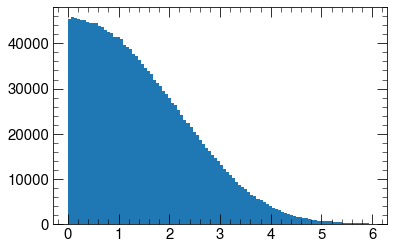

In [97]:
plt.hist(df_all.dEta_SH,100,(0,6))
plt.show()

In [161]:
r_cr_x

45.15599343185552

dat = 1460+-38, mc = 1800+-755
dat / mc = 0.8113+-0.3190


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 8852+-94, mc = 16924+-6796
dat / mc = 0.5230+-0.2045


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


148.80952380952385 239.12151067323487
dat = 10312+-102, mc = 18724+-6838
dat / mc = 0.5507+-0.1957


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 1814+-43, mc = 2604+-1270
dat / mc = 0.6965+-0.3234


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 10392+-102, mc = 15428+-6655
dat / mc = 0.6736+-0.2839


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


148.80952380952385 239.12151067323487
dat = 12206+-110, mc = 18032+-6775
dat / mc = 0.6769+-0.2482


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 1866+-43, mc = 1836+-477
dat / mc = 1.0165+-0.2406


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 12033+-110, mc = 18866+-6814
dat / mc = 0.6378+-0.2246


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


148.80952380952385 239.12151067323487
dat = 13899+-118, mc = 20702+-6831
dat / mc = 0.6714+-0.2158


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 1561+-40, mc = 2391+-925
dat / mc = 0.6529+-0.2360


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


dat = 10421+-102, mc = 7861+-964
dat / mc = 1.3257+-0.1496


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


148.80952380952385 239.12151067323487
dat = 11982+-109, mc = 10252+-1336
dat / mc = 1.1688+-0.1416


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


dat = 1203+-35, mc = 1333+-384
dat / mc = 0.9023+-0.2337


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


dat = 8362+-91, mc = 7917+-1247
dat / mc = 1.0562+-0.1548


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,


148.80952380952385 239.12151067323487
dat = 9565+-98, mc = 9250+-1305
dat / mc = 1.0341+-0.1353


<ipython-input-144-4201de21a058>:134: RuntimeWarning: invalid value encountered in true_divide
  np.append(1+dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:135: RuntimeWarning: invalid value encountered in true_divide
  np.append(1-dbkg/bkg,[0]),
<ipython-input-144-4201de21a058>:144: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
<ipython-input-144-4201de21a058>:144: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(xx,h_4b/bkg,np.sqrt(h_4b)/bkg,w/2,
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3411: RuntimeWarning: invalid value encountered in double_scalars
  low = [v if lo else v - e for v, e, lo in zip(data, a, lolims)]


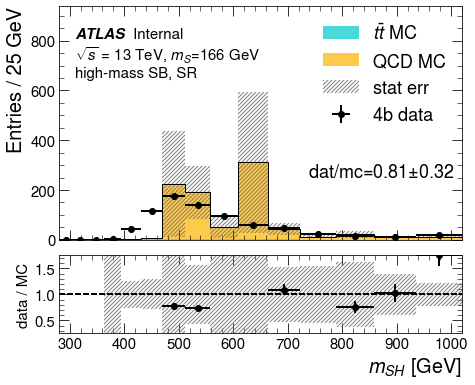

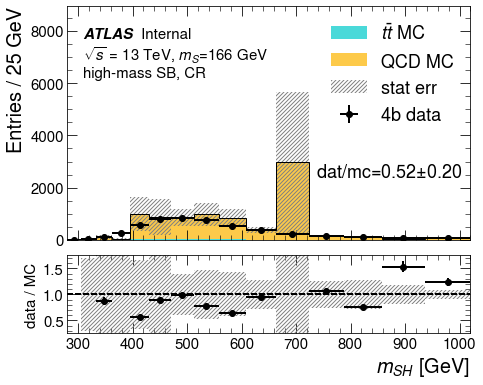

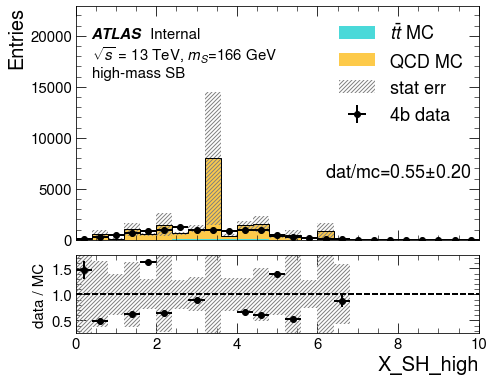

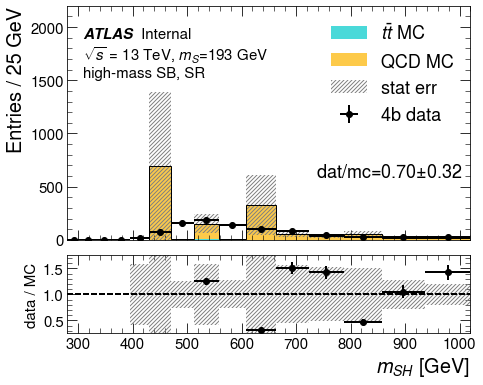

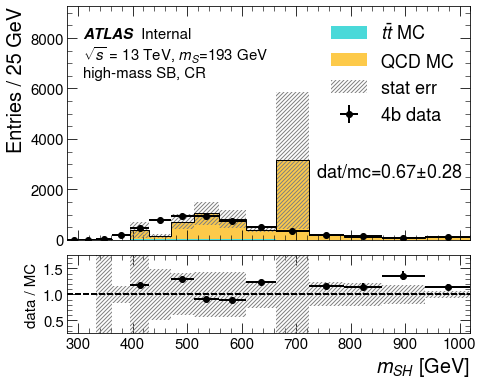

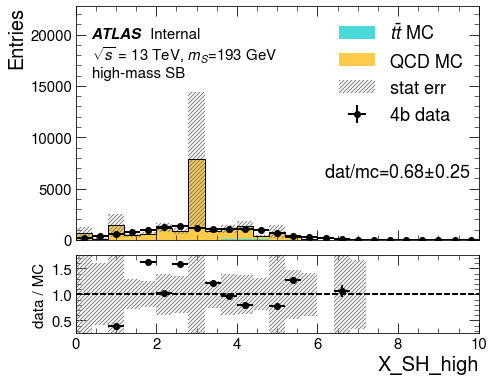

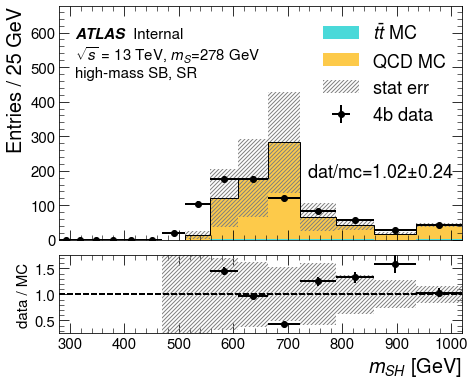

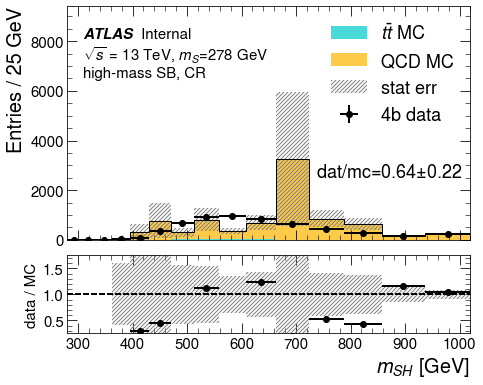

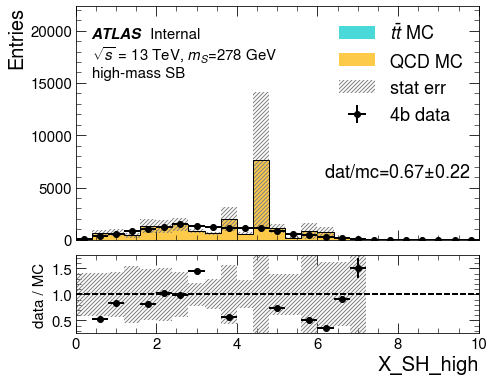

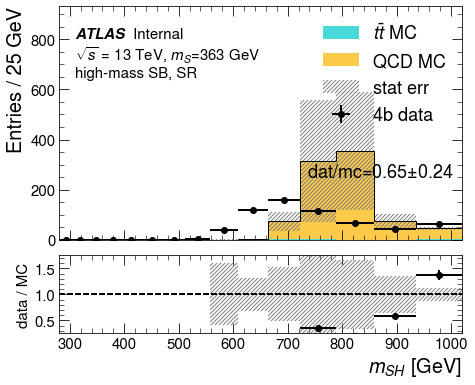

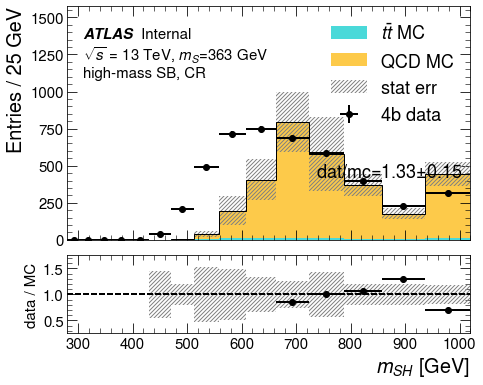

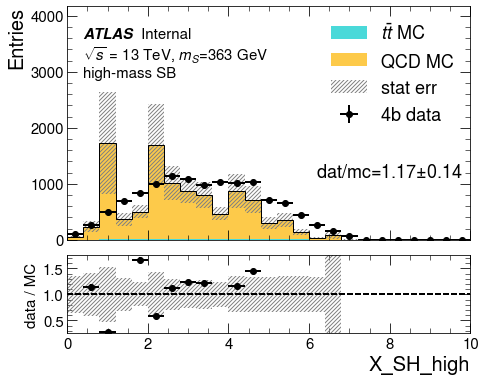

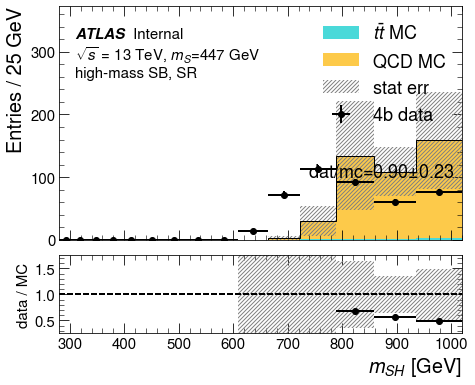

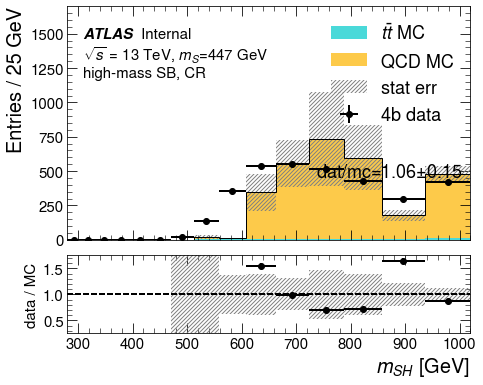

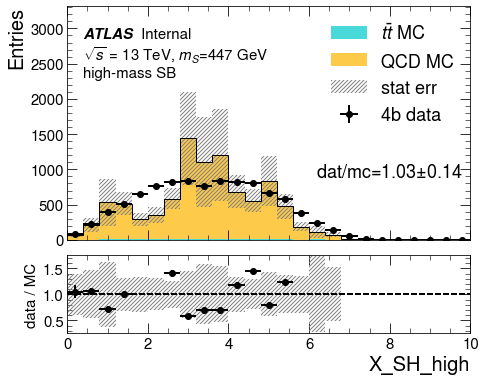

In [168]:
for i_SR,mS_SR in zip([2,3,4,5,6],[166,193,278,363,447]):

    # Redefine X_SH
    xi_low = 125/1.16-r_cr_x
    xi_high = 125/.84+r_cr_x

    for df in [qcd,tt,df_all]:
        
        df['X_SH_low']  = getXhh(df['m_1'],df['m_2'],xi_low,mS_SR,res1=0.1*125/xi_low)
        df['X_SH_high'] = getXhh(df['m_1'],df['m_2'],xi_high,mS_SR,res1=0.1*125/xi_high)
    
    figDir = f'figures/data18/mS{mS_SR}-SBs'
    
    for tag, mH_i in zip(['low','high'], [xi_low,xi_high]):
        
        if tag == 'low':
            continue
        
        X_SH_col = f"X_SH_{tag}"
        
        cuts_SR = {
            "offVar": ["dEta_SH", "X_wt_tag",X_SH_col],
            "offVarCut": [1.5, 1.5, 1.6 ],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt],
            }

        second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV\n{tag}-mass SB"
        v,dv = dataMCCompare(df_all,qcd, tt, cuts_SR, col='m_SH', e=e,ref_val=25,
                      second_tag=second_tag+", SR",
                      xlabel=xlabel,figDir=figDir,tag=f'-{tag}-mass-SB-SR')

        datOverMC.loc[    mS_SR,f'{tag}-mass SB: SR'] = v
        datOverMC_err.loc[mS_SR,f'{tag}-mass SB: SR'] = dv
        
        
        xmin_i = mH_i - r_cr_x
        xmax_i = mH_i + r_cr_x
                      
        yi = mS_SR
        r_cr_y =  1.1* (yi/0.84 - yi/1.16)

        cuts_CR = {
            "offVar": ["dEta_SH", "X_wt_tag",X_SH_col, "m_1","m_1","m_2","m_2"],
            "offVarCut": [1.5, 1.5, 1.6, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,
                         SmoothOperator.gt, SmoothOperator.lt,
                         SmoothOperator.gt, SmoothOperator.lt,
                        ],
            }

        v,dv = dataMCCompare(df_all,qcd, tt, cuts_CR, col='m_SH', e=e,ref_val=25,
                      second_tag=second_tag+", CR",
                      xlabel=xlabel,figDir=figDir,tag=f'-{tag}-mass-SB-CR')
        
        datOverMC.loc[    mS_SR,f'{tag}-mass SB: CR'] = v
        datOverMC_err.loc[mS_SR,f'{tag}-mass SB: CR'] = dv
        
        print(xmin_i,xmax_i)
        '''
        Look at the X_SH modelling
        '''
        cuts_BB = {
            "offVar": ["dEta_SH", "X_wt_tag","m_1","m_1","m_2","m_2"],
            "offVarCut": [1.5, 1.5, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
            "operator": [SmoothOperator.lt, SmoothOperator.gt,
                         SmoothOperator.gt, SmoothOperator.lt,
                         SmoothOperator.gt, SmoothOperator.lt,
                        ],
            }

        v,dv = dataMCCompare(df_all,qcd, tt, cuts_BB, col=X_SH_col, 
                             e=np.linspace(0,10,26),second_tag=second_tag,
                             xlabel=X_SH_col,figDir=figDir,tag=f'-{tag}-mass-SB')

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [145]:
second_tag

'$\\sqrt{s}$ = 13 TeV, $m_S$=447 GeV CR'

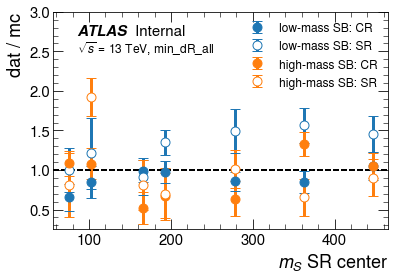

In [182]:
for tag, color in zip(['low','high'],['C0','C1']):#['o','s']):
    for regn, facecolor in zip(['CR','SR'],[color,'w']):
        
        col = f'{tag}-mass SB: {regn}'

        plt.errorbar(datOverMC.index,datOverMC[col],datOverMC_err[col],
                     marker='o',ms=9,markerfacecolor=facecolor,capsize=5, 
                     color=color,lw=0,elinewidth=3,label=col)


xlim = plt.xlim()
plt.plot(xlim,[1]*2,'k--')
plt.xlim(xlim)

plt.ylim(0.25,3)

plt.legend(loc='upper right',fontsize=12)

plt.xlabel('$m_S$ SR center',loc='right',fontsize=18)
plt.ylabel('dat / mc',loc='top',fontsize=18)

ax, fig = plt.gca(),plt.gcf()
second_tag = r"$\sqrt{s}$ = 13 TeV, min_dR_all"
pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=second_tag,ymax=.88,xmin=0.07,
                 line_spacing=0.4,fontsize_label=12)

plt.savefig('figures/data18/datOverMC-SBs.pdf',bbox_inches='tight')
plt.show()

In [179]:
datOverMC_pm = pd.DataFrame(0,mS_SRs,datOverMC.columns)

for i in mS_SRs:
    for col in datOverMC.columns:
        
        v = datOverMC.loc[i,col]
        dv = datOverMC_err.loc[i,col]
        datOverMC_pm.loc[i,col] = f'{v:.2f} $\pm$ {dv:.2f}'

In [180]:
datOverMC_pm

low-mass SB: CR  low-mass SB: SR high-mass SB: CR high-mass SB: SR
75   0.66 $\pm$ 0.17  1.00 $\pm$ 0.28  1.08 $\pm$ 0.16  0.81 $\pm$ 0.40
102  0.85 $\pm$ 0.20  1.21 $\pm$ 0.45  1.08 $\pm$ 0.20  1.92 $\pm$ 0.24
166  0.99 $\pm$ 0.14  0.92 $\pm$ 0.23  0.52 $\pm$ 0.20  0.81 $\pm$ 0.32
193  0.98 $\pm$ 0.14  1.35 $\pm$ 0.16  0.67 $\pm$ 0.28  0.70 $\pm$ 0.32
278  0.86 $\pm$ 0.12  1.49 $\pm$ 0.28  0.64 $\pm$ 0.22  1.02 $\pm$ 0.24
363  0.85 $\pm$ 0.14  1.56 $\pm$ 0.22  1.33 $\pm$ 0.15  0.65 $\pm$ 0.24
447  1.05 $\pm$ 0.18  1.45 $\pm$ 0.22  1.06 $\pm$ 0.15  0.90 $\pm$ 0.23

## Step 2: Quantify signal contamination

In [101]:
dfs = []

load_cols = [ 'X_wt_tag', 'mc_sf', 'truth_mhh_bs', 'm_SH', 'm_H', 'm_S', 'dEta_SH', 'X_SH', 'correct',]
# 'pt_SH', 'pt_H', 'eta_H', 'phi_H', 'pt_S', 'eta_S', 'phi_S',
# 'correctPair',  'chosenPair', 

mX = 750
mS_list = [70,100,170,200,300,400,500]

for i,mS in enumerate(mS_list):
    fname = f'../data/X{mX}_S{mS}_mc20e-MAR23/df_min_dR_all_4b_DL1d77_4b.parquet'
    dfs.append(pd.read_parquet(fname,columns=load_cols))
    # break


Let's start just overlaying the signal and the background in the SR and CR for $m_S = 70$ GeV.

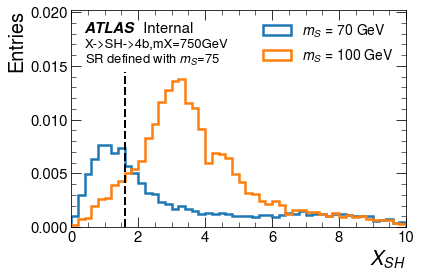

In [102]:
mS_SR = 75
lw=2

for df in dfs[:2]:
    df['m_1'] = df['m_H']
    df['m_2'] = df['m_S'] 
    
for df in dfs[2:]+[qcd,tt]:
    df['m_1'] = df['m_S']
    df['m_2'] = df['m_H'] 
    
for df in dfs+[qcd,tt]:    
    df['X_SH'] = getXhh(df['m_1'],df['m_2'],125,mS_SR)


sr = []

for i,(mS,df) in enumerate(zip(mS_list,dfs[:2])):
    
    m = (df.dEta_SH < 1.5) & (df.X_wt_tag > 1.5)
    plt.hist(df.loc[m,'X_SH'],50,(0,10),label=f'$m_S$ = {mS} GeV',
             histtype='step',lw=2.5,weights=df.loc[m,'mc_sf'])
    
    sr.append(np.sum(df.loc[m & (df.X_SH < 1.6),'mc_sf']))
    
ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k',lw=lw,ls='--')

fig = plt.gcf()
ax = plt.gca()

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=f'X->SH->4b,mX={mX}GeV\nSR defined with $m_S$={mS_SR}',
                 ymax=.88,line_spacing=0.3,fontsize_label=13)

plt.xlim(0,10)
plt.ylim(0,ylim[1]*1.4)

plt.xlabel('$X_{SH}$',fontsize=20,loc='right')
plt.ylabel('Entries',loc='top',fontsize=20)
plt.legend()

plt.savefig(f'figures/mX750_mS{mS_SR}/X_SH.pdf',bbox_inches='tight')

plt.show()

In [103]:
sr[0] / sr[1]

2.5930166

In [104]:
import matplotlib
from plotUtils import rainbow_text
from trigger import offline_mask

In [105]:
def sigBkgCompare(sigs, qcd, tt, cuts, col='m_SH',e=None,
                  sig_colors=[],sig_labels=[],
                  xlabel=None,
                  second_tag= r"$\sqrt{s}$ = 13 TeV, SH4b",
                  ref_val=-1,log=True,
                  figDir='',tag=''):
    '''
    Goal: Look at a MC prediction, and compare to the data prediction.
    
    Inputs:
    - dat: df for the data
    - qcd: df for the QCD MC
    - tt: df for the ttbar MC
    - cuts: dictionary for the 
    - col: The column to plot
    - e: The bin edges, if None (default) will be inferred automatically
    - ref_val: If -1, what to norm the hist scale to (for var width bins)
    - figDir: Dir to save the fig in (only saves when this is _not_ an empty string)
    - tag: Tag to append to the figname 
    
    Under / overflow is taken care of automatically
    '''
 
    # Sanity check that cuts has the right keys
    assert ('offVar' in cuts) and ('offVarCut' in cuts) and ('operator' in cuts)

    '''
    Define the masks
    '''
    m_qcd = offline_mask(qcd,cuts)
    m_tt = offline_mask(tt,cuts)
    
    '''
    Define the histograms
    '''
    eps = .001
    
    v_tt  = np.clip(tt.loc[m_tt,col], e[0]+eps, e[-1]-eps)
    v_qcd = np.clip(qcd.loc[m_qcd,col], e[0]+eps, e[-1]-eps)
    
    if e is None:
        hmin = np.min(np.append(v_tt,v_qcd))
        hmax = np.max(np.append(v_tt,v_qcd))
        e = np.linspace(hmin,hmax,26)
    
    h_tt = np.histogram(v_tt,e,weights=tt.loc[m_tt,'mc_sf'])[0]

    h_qcd = np.histogram(v_qcd,e, 
                         weights=qcd.loc[m_qcd,'mc_sf'])[0]

    # add the combined background estimate
    bkg = h_tt+h_qcd

    # add an errorbar
    ws = np.append(tt.loc[m_tt,'mc_sf'], qcd.loc[m_qcd,'mc_sf'])
    dbkg = np.sqrt(np.histogram(np.append(v_tt,v_qcd), e,
                                weights=ws**2)[0])
    
    '''
    Draw the histograms
    '''
    xx = 0.5 * (e[1:]+e[:-1])
    w = e[1:] - e[:-1]
    elw = 2
    
    if ref_val != -1:
        scale=ref_val/w
        ylabel=f'Entries / {ref_val} GeV' 
    else:
        scale = 1
        ylabel='Entries'

    fig, [ax1,ax2] = plt.subplots( 2,1,figsize=(7, 5.9),sharex=True,
                                  gridspec_kw={ "height_ratios": [0.75, 0.25],
                                                "hspace": 0.1,
                                                 "left": 0.1, "bottom": .11,})
    
    ax1.hist(xx,e,label=r'$t\bar{t}$ MC', color='#4ad9d9', # lightturquoise
             weights=h_tt*scale)

    ax1.hist(xx,e,label='QCD MC',color='#fdc536',alpha=.9, # darkyellow
             bottom=h_tt*scale, weights=h_qcd*scale)
    ax1.hist(xx,e,weights=bkg*scale,histtype='step',color='k')

    ax1.fill_between(e,
                     np.append((bkg+dbkg) * scale,[0]),
                     np.append((bkg-dbkg) * scale,[0]),
                     color='grey',step='post',
                     hatch='//////',
                     fc= "None",
                     edgecolor= "grey",
                     # label='stat err',
                     lw= 0,
                     zorder=2
                    )

    # Loop over the signal files and overlay the histograms
    text = []
    for sig, sig_color,l in zip(sigs,sig_colors,sig_labels):
    
        m_sig = offline_mask(sig,cuts)
        v_sig  = np.clip(sig.loc[m_sig,col], e[0]+eps, e[-1]-eps)
        h_sig = np.histogram(v_sig,e,weights=sig.loc[m_sig,'mc_sf'])[0]

        lw=2
        ax1.hist(xx,e,histtype='step',color=sig_color, lw=lw, label=l,
                 weights=scale*h_sig)
        
        m=bkg>0
        ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
    
        text.append(f'S/B = {np.sum(h_sig) / np.sum(bkg):1.1g}')

        
        print(f'\nS/B = {np.sum(h_sig) / np.sum(bkg):1.1g}')
        print(f'S/B ({e[10]:.0f}<m_SH<{e[13]:.0f}) = {np.sum(h_sig[10:13]) / np.sum(bkg[10:13]):1.1g}')
        print(f'quad sum S/sqrt(B) = {np.sqrt(np.sum(h_sig[m]**2/bkg[m])):1.1g}')
    
    
    rainbow_text(e[1], 0.9*plt.ylim()[1], text, sig_colors, 
                  ax=ax2,ha='left',va='top', yoffset=1.1,
                 fontsize=15)
   
    '''
    Add annotations
    '''
    ax1.legend(fontsize=14,labelspacing=0,loc='upper right')
    ax1.set_ylabel(ylabel,loc='top',fontsize=20)
    ax2.set_xlabel(col if xlabel is None else xlabel,loc='right',fontsize=20)
    ax2.set_ylabel('sig / bkg')

    pas.makeATLAStag(ax1, fig, first_tag=' Simulation Internal',
                     second_tag=second_tag,
                     ymax=.85,line_spacing=0.8)

    ylim = ax1.get_ylim()
    
    if log:
        ax1.set_yscale('log')
        
        ax1.set_ylim(ylim[0],1000*ylim[1])

        locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax1.set_ylim(0,1.5*ylim[1])
        
    ax2.set_xlim(e[[0,-1]])
    # ax2.set_ylim(0)

    if figDir:
        if log:
            tag += '-log'
        plt.savefig(f'{figDir}/{col}{tag}.pdf',bbox_inches='tight')


S/B = 6e-06
S/B (663<m_SH<858) = 0.0002
quad sum S/sqrt(B) = 0.003

S/B = 2e-06
S/B (663<m_SH<858) = 4e-05
quad sum S/sqrt(B) = 0.0009


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])


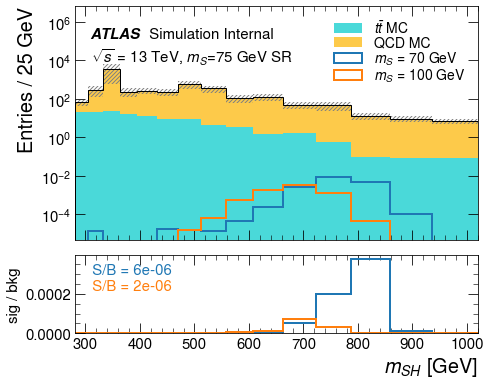

In [106]:
cuts_SR_70 = {
    "offVar": ["dEta_SH", "X_wt_tag","X_SH"],
    "offVarCut": [1.5, 1.5, 1.6 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt],
    }

second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV SR"
figDir = f'figures/mX750_mS{mS_SR}'
xlabel = '$m_{SH}$ [GeV]'
sigBkgCompare(dfs[:2],qcd, tt, cuts_SR_70, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,#log=False,
              sig_colors=[f'C{i}' for i in range(len(mS_list))],
              sig_labels=[f'$m_S$ = {mS} GeV' for mS in mS_list],
              xlabel=xlabel,figDir=figDir,tag='-SR')

In [107]:
xx[10:13]

array([693. , 755.5, 823. ])

Then make the same plot for the CR.

**New nomenclature**
- m1 is the _minimim_ dRjj
- m2 is the _other_ dRjj

In [108]:
df.columns

Index(['X_wt_tag', 'mc_sf', 'truth_mhh_bs', 'm_SH', 'm_H', 'm_S', 'dEta_SH',
       'X_SH', 'correct', 'm_1', 'm_2'],
      dtype='object')

In [109]:
xi

125

In [110]:
r_cr_x = 1.1* (xi/0.84 - xi/1.16)
xmin_i = xi - r_cr_x
xmax_i = xi + r_cr_x

yi = mS_SR
r_cr_y =  1.1* (yi/0.84 - yi/1.16)

y_cr_i = yi #*1.05
ymin_i = y_cr_i - r_cr_y
ymax_i = y_cr_i + r_cr_y


S/B = 4e-07
S/B (663<m_SH<858) = 2e-05
quad sum S/sqrt(B) = 0.0008

S/B = 7e-07
S/B (663<m_SH<858) = 3e-05
quad sum S/sqrt(B) = 0.001


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])


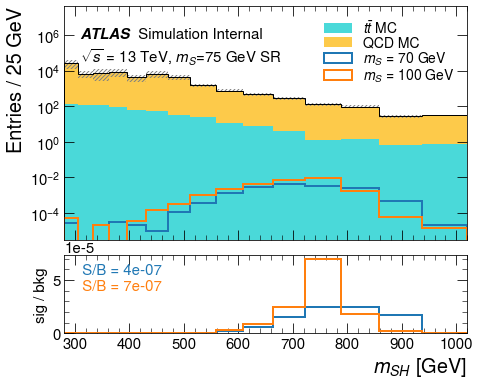

In [111]:
cuts_CR_70 = {
    "offVar": ["dEta_SH", "X_wt_tag","X_SH", "m_1","m_1","m_2","m_2"],
    "offVarCut": [1.5, 1.5, 1.6, xmin_i,xmax_i, ymin_i,ymax_i],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,
                 SmoothOperator.gt, SmoothOperator.lt,
                 SmoothOperator.gt, SmoothOperator.lt,
                ],
    }

sigBkgCompare(dfs[:2],qcd, tt, cuts_CR_70, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,
              sig_colors=[f'C{i}' for i in range(len(mS_list))],
              sig_labels=[f'$m_S$ = {mS} GeV' for mS in mS_list],
              xlabel=xlabel,figDir=figDir,tag='-CR')

**Conclusion** Order or magnitude less signal here... should be ok?

### Next: $m_S$ = 100 GeV SR

This is a little tricky b/c the 170 GeV neighbor is going to have a different definition.

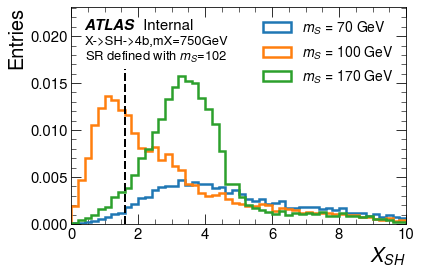

In [112]:
mS_SR = 102
    
for df in dfs+[qcd,tt]:    
    df['X_SH'] = getXhh(df['m_1'],df['m_2'],125,mS_SR)

sr = []

for i,(mS,df) in enumerate(zip(mS_list,dfs[:3])):
    
    m = (df.dEta_SH < 1.5) & (df.X_wt_tag > 1.5)
    plt.hist(df.loc[m,'X_SH'],50,(0,10),label=f'$m_S$ = {mS} GeV',
             histtype='step',lw=2.5,weights=df.loc[m,'mc_sf'])
    
    sr.append(np.sum(df.loc[m & (df.X_SH < 1.6),'mc_sf']))
    
ylim = plt.ylim()
plt.plot([1.6]*2,ylim,'k',lw=lw,ls='--')

fig = plt.gcf()
ax = plt.gca()

pas.makeATLAStag(ax, fig, first_tag=' Internal',
                 second_tag=f'X->SH->4b,mX={mX}GeV\nSR defined with $m_S$={mS_SR}',
                 ymax=.88,line_spacing=0.3,fontsize_label=13)

plt.xlim(0,10)
plt.ylim(0,ylim[1]*1.4)

plt.xlabel('$X_{SH}$',fontsize=20,loc='right')
plt.ylabel('Entries',loc='top',fontsize=20)
plt.legend()

plt.savefig(f'figures/mX750_mS{mS_SR}/X_SH.pdf',bbox_inches='tight')

plt.show()


S/B = 5e-07
S/B (663<m_SH<858) = 8e-06
quad sum S/sqrt(B) = 0.0003

S/B = 8e-06
S/B (663<m_SH<858) = 0.0002
quad sum S/sqrt(B) = 0.004

S/B = 1e-06
S/B (663<m_SH<858) = 8e-06
quad sum S/sqrt(B) = 0.0004


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 1e-06
S/B (663<m_SH<858) = 3e-05
quad sum S/sqrt(B) = 0.002

S/B = 2e-06
S/B (663<m_SH<858) = 4e-05
quad sum S/sqrt(B) = 0.002

S/B = 2e-06
S/B (663<m_SH<858) = 3e-05
quad sum S/sqrt(B) = 0.001


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])


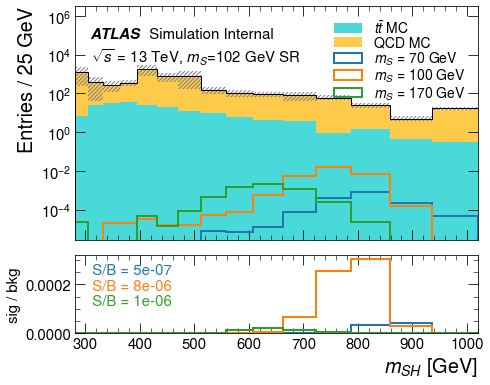

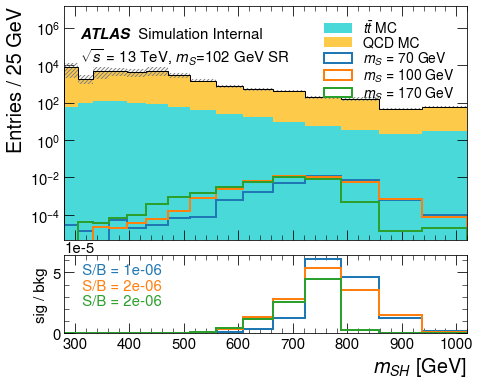

In [113]:
second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV SR"
figDir = f'figures/mX750_mS{mS_SR}'

cuts_SR_70 = {
    "offVar": ["dEta_SH", "X_wt_tag","X_SH"],
    "offVarCut": [1.5, 1.5, 1.6 ],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt],
    }

sigBkgCompare(dfs[:3],qcd, tt, cuts_SR_70, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,#log=False,
              sig_colors=[f'C{i}' for i in range(len(mS_list))],
              sig_labels=[f'$m_S$ = {mS} GeV' for mS in mS_list],
              xlabel=xlabel,figDir=figDir,tag='-SR')


yi = mS_SR
r_cr_y =  1.1* (yi/0.84 - yi/1.16)

cuts_CR = {
    "offVar": ["dEta_SH", "X_wt_tag","X_SH", "m_1","m_1","m_2","m_2"],
    "offVarCut": [1.5, 1.5, 1.6, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
    "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,
                 SmoothOperator.gt, SmoothOperator.lt,
                 SmoothOperator.gt, SmoothOperator.lt,
                ],
    }

sigBkgCompare(dfs[:3],qcd, tt, cuts_CR, col='m_SH', e=e,ref_val=25,
              second_tag=second_tag,
              sig_colors=[f'C{i}' for i in range(len(mS_list))],
              sig_labels=[f'$m_S$ = {mS} GeV' for mS in mS_list],
              xlabel=xlabel,figDir=figDir,tag='-CR')

### The higher masses

$m_S = 170,200,300,400,500$

In [114]:
for df in dfs[:2]:
    df['m_1'] = df['m_S']
    df['m_2'] = df['m_H'] 
    
for df in dfs[2:]+[qcd,tt]:
    df['m_1'] = df['m_H']
    df['m_2'] = df['m_S'] 

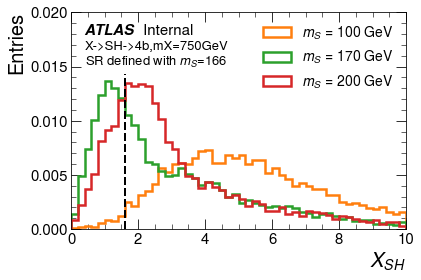

<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 6e-07
S/B (663<m_SH<858) = 2e-06
quad sum S/sqrt(B) = 0.0003

S/B = 1e-05
S/B (663<m_SH<858) = 7e-05
quad sum S/sqrt(B) = 0.003

S/B = 8e-06
S/B (663<m_SH<858) = 4e-05
quad sum S/sqrt(B) = 0.002

S/B = 3e-06
S/B (663<m_SH<858) = 4e-05
quad sum S/sqrt(B) = 0.002

S/B = 2e-06
S/B (663<m_SH<858) = 2e-05
quad sum S/sqrt(B) = 0.001

S/B = 2e-06
S/B (663<m_SH<858) = 3e-05
quad sum S/sqrt(B) = 0.002


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])


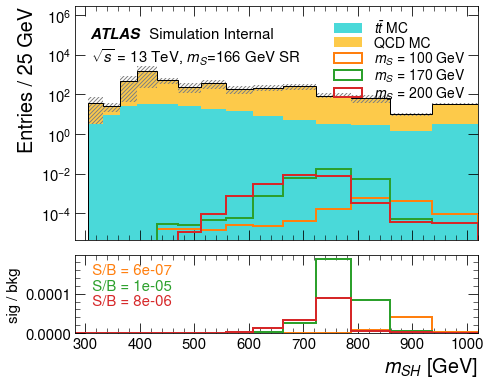

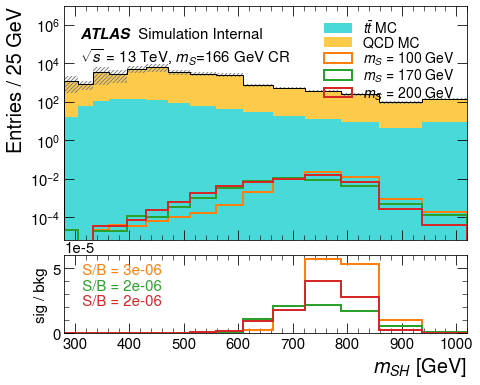

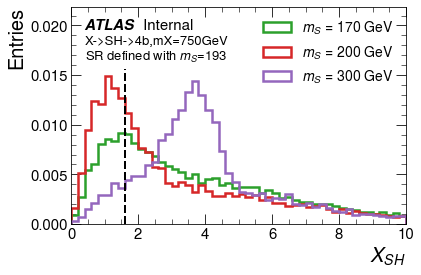

<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 8e-06
S/B (663<m_SH<858) = 7e-05
quad sum S/sqrt(B) = 0.002

S/B = 1e-05
S/B (663<m_SH<858) = 0.0001
quad sum S/sqrt(B) = 0.003

S/B = 3e-06
S/B (663<m_SH<858) = 6e-06
quad sum S/sqrt(B) = 0.0004

S/B = 2e-06
S/B (663<m_SH<858) = 2e-05
quad sum S/sqrt(B) = 0.001

S/B = 2e-06
S/B (663<m_SH<858) = 1e-05
quad sum S/sqrt(B) = 0.0009

S/B = 1e-06
S/B (663<m_SH<858) = 5e-06
quad sum S/sqrt(B) = 0.0005


<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])


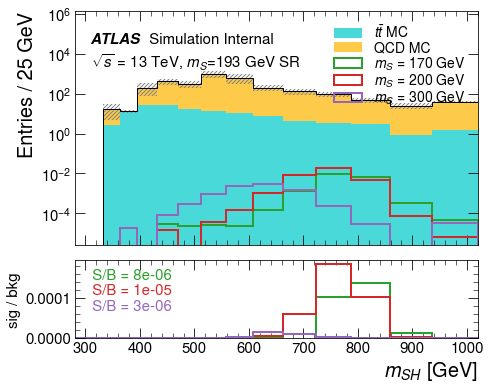

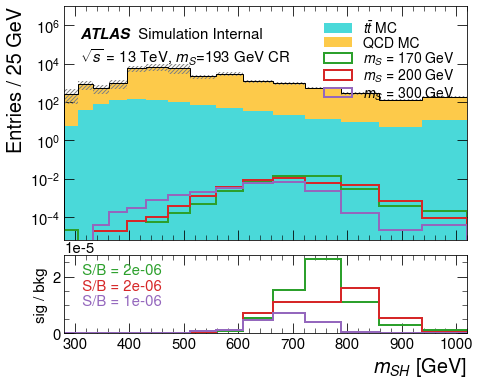

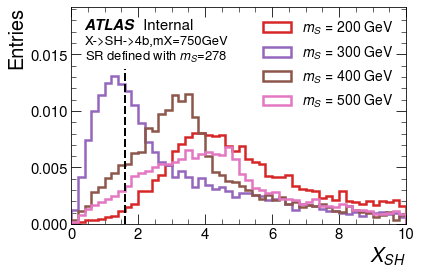

<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 8e-07
S/B (663<m_SH<858) = 2e-06
quad sum S/sqrt(B) = 0.0001

S/B = 1e-05
S/B (663<m_SH<858) = 6e-05
quad sum S/sqrt(B) = 0.002

S/B = 5e-06
S/B (663<m_SH<858) = 6e-06
quad sum S/sqrt(B) = 0.0005

S/B = 3e-06
S/B (663<m_SH<858) = 8e-06
quad sum S/sqrt(B) = 0.0003


<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 3e-06
S/B (663<m_SH<858) = 2e-05
quad sum S/sqrt(B) = 0.001

S/B = 2e-06
S/B (663<m_SH<858) = 8e-06
quad sum S/sqrt(B) = 0.0007

S/B = 2e-06
S/B (663<m_SH<858) = 6e-06
quad sum S/sqrt(B) = 0.0006

S/B = 1e-06
S/B (663<m_SH<858) = 4e-06
quad sum S/sqrt(B) = 0.0004


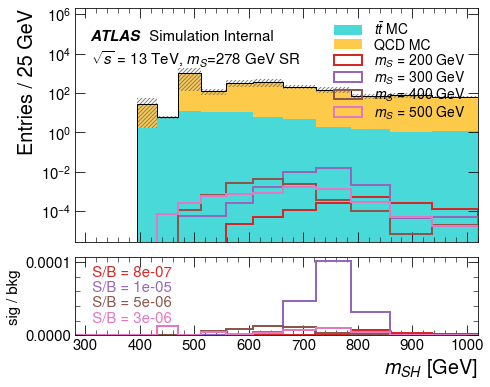

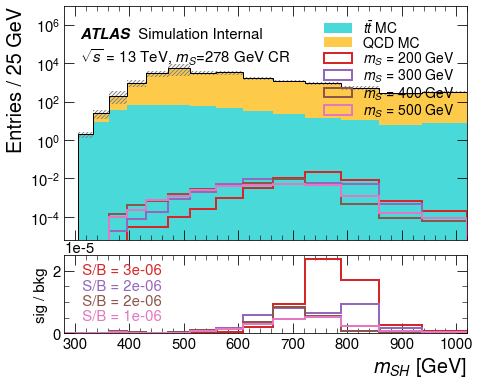

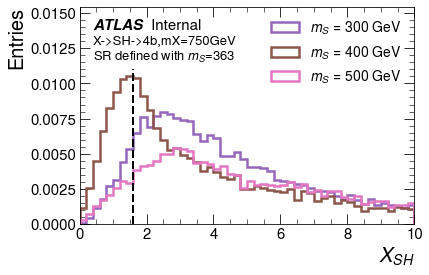

<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 6e-06
S/B (663<m_SH<858) = 9e-06
quad sum S/sqrt(B) = 0.0007

S/B = 2e-05
S/B (663<m_SH<858) = 3e-05
quad sum S/sqrt(B) = 0.001

S/B = 5e-06
S/B (663<m_SH<858) = 4e-06
quad sum S/sqrt(B) = 0.0004


<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 4e-06
S/B (663<m_SH<858) = 1e-05
quad sum S/sqrt(B) = 0.001

S/B = 3e-06
S/B (663<m_SH<858) = 6e-06
quad sum S/sqrt(B) = 0.0007

S/B = 2e-06
S/B (663<m_SH<858) = 5e-06
quad sum S/sqrt(B) = 0.0005


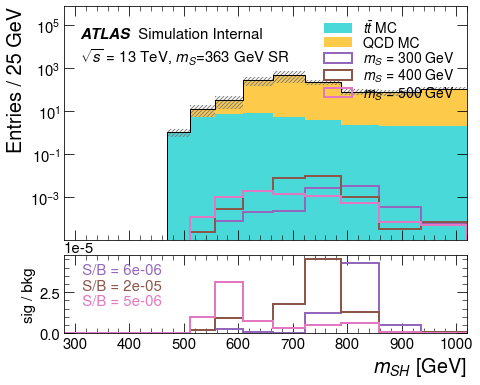

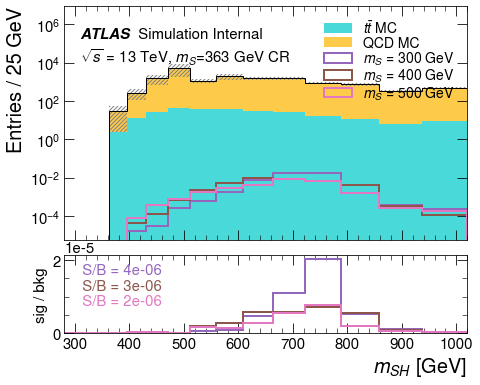

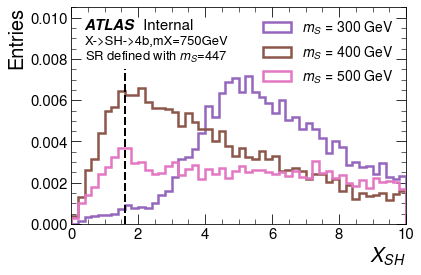

<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 1e-06
S/B (663<m_SH<858) = 9e-07
quad sum S/sqrt(B) = 7e-05

S/B = 1e-05
S/B (663<m_SH<858) = 1e-05
quad sum S/sqrt(B) = 0.0009

S/B = 7e-06
S/B (663<m_SH<858) = 7e-06
quad sum S/sqrt(B) = 0.0007


<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:110: RuntimeWarning: invalid value encountered in true_divide
  ax2.hist(xx, e, histtype='step', color=sig_color,lw=lw, weights=np.where(m,h_sig/bkg,0))
<ipython-input-105-8ae66106af66>:141: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],1000*ylim[1])



S/B = 5e-06
S/B (663<m_SH<858) = 9e-06
quad sum S/sqrt(B) = 0.0009

S/B = 6e-06
S/B (663<m_SH<858) = 9e-06
quad sum S/sqrt(B) = 0.001

S/B = 3e-06
S/B (663<m_SH<858) = 5e-06
quad sum S/sqrt(B) = 0.0005


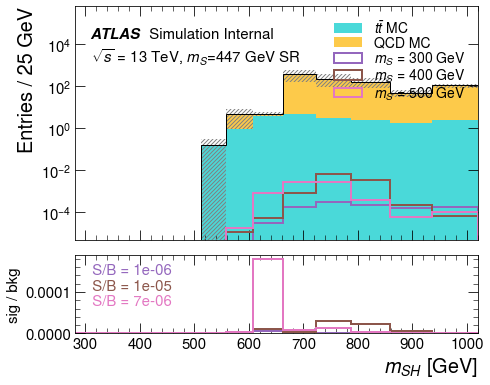

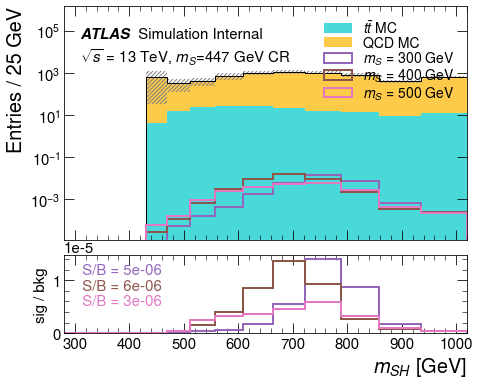

In [115]:
for i,mS_SR in zip([2,3,4,5,6],[166,193,278,363,447]):

    '''
    Redefine X_SH
    '''
    for df in dfs+[qcd,tt]:    
        df['X_SH'] = getXhh(df['m_1'],df['m_2'],125,mS_SR)

    '''
    X_SH plot
    '''
    i_min = i-2 if i ==6 else i-1
    i_max = i+3 if i ==4 else i+2
    sig_colors=[]
    sig_labels=[]
    
    plt.figure()
    for ii,mS,df in zip(range(i_min,i_max),mS_list[i_min:i_max],dfs[i_min:i_max]):

        l = f'$m_S$ = {mS} GeV'
        
        m = (df.dEta_SH < 1.5) & (df.X_wt_tag > 1.5)
        plt.hist(df.loc[m,'X_SH'],50,(0,10),label=l,color=f'C{ii}',
                 histtype='step',lw=2.5,weights=df.loc[m,'mc_sf'])

        sig_colors.append(f'C{ii}')
        sig_labels.append(l)
        
    ylim = plt.ylim()
    plt.plot([1.6]*2,ylim,'k',lw=lw,ls='--')

    fig = plt.gcf()
    ax = plt.gca()

    pas.makeATLAStag(ax, fig, first_tag=' Internal',
                     second_tag=f'X->SH->4b,mX={mX}GeV\nSR defined with $m_S$={mS_SR}',
                     ymax=.88,line_spacing=0.3,fontsize_label=13)

    plt.xlim(0,10)
    plt.ylim(0,ylim[1]*1.4)

    plt.xlabel('$X_{SH}$',fontsize=20,loc='right')
    plt.ylabel('Entries',loc='top',fontsize=20)
    plt.legend()

    plt.savefig(f'figures/mX750_mS{mS_SR}/X_SH.pdf',bbox_inches='tight')
    plt.show()
    
    
    second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV SR"
    figDir = f'figures/mX750_mS{mS_SR}'

    cuts_SR = {
        "offVar": ["dEta_SH", "X_wt_tag","X_SH"],
        "offVarCut": [1.5, 1.5, 1.6 ],
        "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.lt],
        }

    sigBkgCompare(dfs[i_min:i_max],qcd, tt, cuts_SR, col='m_SH', e=e,ref_val=25,
                  second_tag=second_tag,
                  sig_colors=sig_colors,
                  sig_labels=sig_labels,
                  xlabel=xlabel,figDir=figDir,tag='-SR')


    yi = mS_SR
    r_cr_y =  1.1* (yi/0.84 - yi/1.16)

    cuts_CR = {
        "offVar": ["dEta_SH", "X_wt_tag","X_SH", "m_1","m_1","m_2","m_2"],
        "offVarCut": [1.5, 1.5, 1.6, xmin_i,xmax_i, yi - r_cr_y,yi + r_cr_y],
        "operator": [SmoothOperator.lt, SmoothOperator.gt,SmoothOperator.gt,
                     SmoothOperator.gt, SmoothOperator.lt,
                     SmoothOperator.gt, SmoothOperator.lt,
                    ],
        }
    second_tag = r"$\sqrt{s}$ = 13 TeV, "+f"$m_S$={mS_SR} GeV CR"
    
    sigBkgCompare(dfs[i_min:i_max],qcd, tt, cuts_CR, col='m_SH', e=e,ref_val=25,
                  second_tag=second_tag,
                  sig_colors=sig_colors,
                  sig_labels=sig_labels,
                  xlabel=xlabel,figDir=figDir,tag='-CR')
    
    